## Introduction

The purpose of this notebook is a basic exploration of the NSL-KDD dataset. Here are the goals of this exploration:
* Gain a basic understanding of the data set
* Look at how the data set might be used to predict network anomalies or attacks
* Walk through some fundemental concepts of building machine learning models

Throughout we'll do some work by hand that could be done in more effective ways using delivered functionality within sci-kit. The intent here is to be more deliberate about the process of understanding what we're doing and why. We will look at how to approach some of these problems using the built-in toools in a later notebook.

## Dataset

#### Description

NSL-KDD dataset is a refined version of the KDD cup 99 dataset (a well
known benchmark for the research of Intrusion Detection techniques). It contains
the essential records of its predecessor balancing the proportion of normal versus
attack traces, and excluding redundant records. Each record is composed of 41
attributes unfolding four different types of features of the flow, and its assigned
label which classifies it as an attack or as normal. These features include basic
characteristics of each network connection vector such as the duration or the
number of bytes transferred, content related features like the number of "root"
accesses, contextual time related traffic features such as the number of connections
to the same destination, and host based traffic features like the number of
connections to the same port number. The whole amount of records covers one
normal class and four attack classes grouped as denial of service (DoS), surveillance
(Probe), unauthorized access to local super user (R2L) and unauthorized
access from a remote machine (U2R).

#### Feature description

- Duration: duration of connection(in seconds)
- protocol_type: type of protocol
- Service: Network type
- Flag: Flag status
- Src_bytes: Number of bytes transferred from source to destination
- Dst_bytes: Number of bytes transferred from destination to source
- Land: If connection is to same host land=1, else 0
- Wrong_fragment: Number of wrong fragments
- Urgent: Number of urgent packets
- Hot: Number of “hot” indicators
- Num_failed_logins: Number of failed logins
- Logged_in: If logged in logged_in=1, else 0
- num_compromised: Number of compromised conditions
- root_shell: If root shell is obtained root_shell=1, else 0
- su_attempted: If “su root” accesses, su_attempted=1, else 0
- num_root: Number of accessed roots
- num_file_creations: Number of file creations
- num_shells Number: of shell prompt
- num_access_files: Number of operations on access files
- num_outbound_cmds: Number of outbound commands
- is_host_login: If login is hot is_host_login=1, else 0
- is_guest_login: If login is guest is_guest_login=1, else 0
- Count: No. Number of connections to the same host in last 2 seconds
- srv_count: Number of connections to the same service in last 2 seconds
- serror_rate: Percentage of connection with syn error
- srv_serror_rate: Percentage of connection with syn error
- rerror_rate: Percentage of connection with rej error
- srv_rerror_rate: Percentage of connection with rej error
- same_srv_rate: Percentage of connection of same service
- diff_srv_rate: Percentage of connection of different service
- srv_diff_host_rate: Percentage of connection of different hosts
- dst_host_count: Number of connections of same destination host
- dst_host_srv_count: Number of connections of same destination host and service
- dst_host_same_srv_rate: Percentage of connections having same destination host and service
- dst_host_diff_srv_rate: Percentage of connections having different service on current host
- dst_host_same_src_port_rate: Percentage of connections of current host having same src port
- dst_host_srv_diff_host_rate: Percentage of connection of same service and different hosts
- dst_host_serror_rate: Percentage of connections of current host having S0 error
- dst_host_srv_serror_rate: Percentage of connections of current host of a service having S0 error
- dst_host_rerror_rate: Percentage of connections of current host that have rst error
- dst_host_srv_rerror_rate: Percentage of connections of current host of service that have rst error
- xAttack: Type of attack

There are 4 basic type of class:
- DoS(Denial of Service): It is one of the most harmful attacks. These type of attacks restrict the user from using certain services. The attacker tries to overload the system or keep the resources busy in the network and does not allow the user to access services.
- U2R: In this kind of attack, the attacker tries to gain access to the system as a root user. The attacker tries to gain access to all data of the system and have full control on the server.
- R2L: In this attack, the attacker tries to gain access to a system by sending some message to the server and gaining access to system from a remote machine. The attacker makes some changes to the server to get access to resources. One of the examples being guessing passwords.
- Probe attacks: This attack aims to analysing the network, gather information. This attack is generally performed to be able to attack through some other methods later.

## Importing libraries

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import warnings
from sklearn.preprocessing import normalize
import scipy.stats
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,  roc_auc_score, confusion_matrix, classification_report

## Reading and understanding the dataset

We've put features names in `feature_names` variable so we can assign it later to our training data.

In [240]:
feature_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","xAttack","level"]

Let's load our training and test data with assigned features names.

In [528]:
train = pd.read_csv('KDDTrain+.txt')
test = pd.read_csv('KDDTest+.txt')

In [529]:
train.columns = feature_names
test.columns = feature_names

## Training data at first sight

Let's look at first 5 records of our training data.

In [530]:
train.head(20)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
5,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,REJ,0,0,0,0,0,0,...,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21


Let's look at last 5 records of our training data.

In [531]:
train.tail()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack,level
125967,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125968,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.0,0.00,0.0,0.00,0.0,normal,21
125969,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.0,0.72,0.0,0.01,0.0,normal,18
125970,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125971,0,tcp,ftp_data,SF,151,0,0,0,0,0,...,0.30,0.03,0.30,0.0,0.00,0.0,0.00,0.0,normal,21


<div style="border-radius:5px;border:#283149 solid;background-color:#FFFFFF; padding:20px; font-size:15px">    
    <strong>📝 Data Information</strong>
    <br>
We indeed see the following: <br>
- binary variables <br>
- categorical variables <br>
- Numerical variables

Let's look at our training data dimensions

<div style="border-radius:5px;border:#283149 solid;background-color:#FFFFFF; padding:20px; font-size:15px">    
We have 43 variables and 125973 rows. Let's see if we have the same number of variables in the test data.

In [532]:
train.shape

(125972, 43)

<div style="border-radius:5px;border:#283149 solid;background-color:#FFFFFF; padding:20px; font-size:15px">    
We have 43 variables and 125973 rows. Let's see if we have the same number of variables in the test data.

In [533]:
test.shape

(22543, 43)

<div style="border-radius:5px;border:#283149 solid;background-color:#FFFFFF; padding:20px; font-size:15px">    
We realize that we have the same number of variables in test data.

## Test data at first sight

Let's look at first 5 records of our test data.

In [534]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack,level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
3,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
4,0,tcp,http,SF,267,14515,0,0,0,0,...,1.00,0.00,0.01,0.03,0.01,0.0,0.00,0.00,normal,21


Let's look at last 5 records of our test data.

In [535]:
test.tail()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack,level
22538,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22539,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22540,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back,15
22541,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal,21
22542,0,tcp,sunrpc,REJ,0,0,0,0,0,0,...,0.08,0.03,0.00,0.00,0.00,0.0,0.44,1.00,mscan,14


## Statistical summary

Let's get a statistical information on our training dataset

In [536]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,...,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,...,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5.870354e+06,4.021285e+06,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,...,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


Let's now invesigate how many variables of each type we have.

In [537]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

Before we create any visualization, we need to understand the type of data for each of the columns of the dataset.
As we can see, we have both of the numerical and cateogrical features.

#### Numerical features

We identify numerical features and assign them to `numerical_features` variable.

In [538]:
numerical_features = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
numerical_features

['duration',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'level']

After, we will display the frequency distribution for each numerical features using histograms.

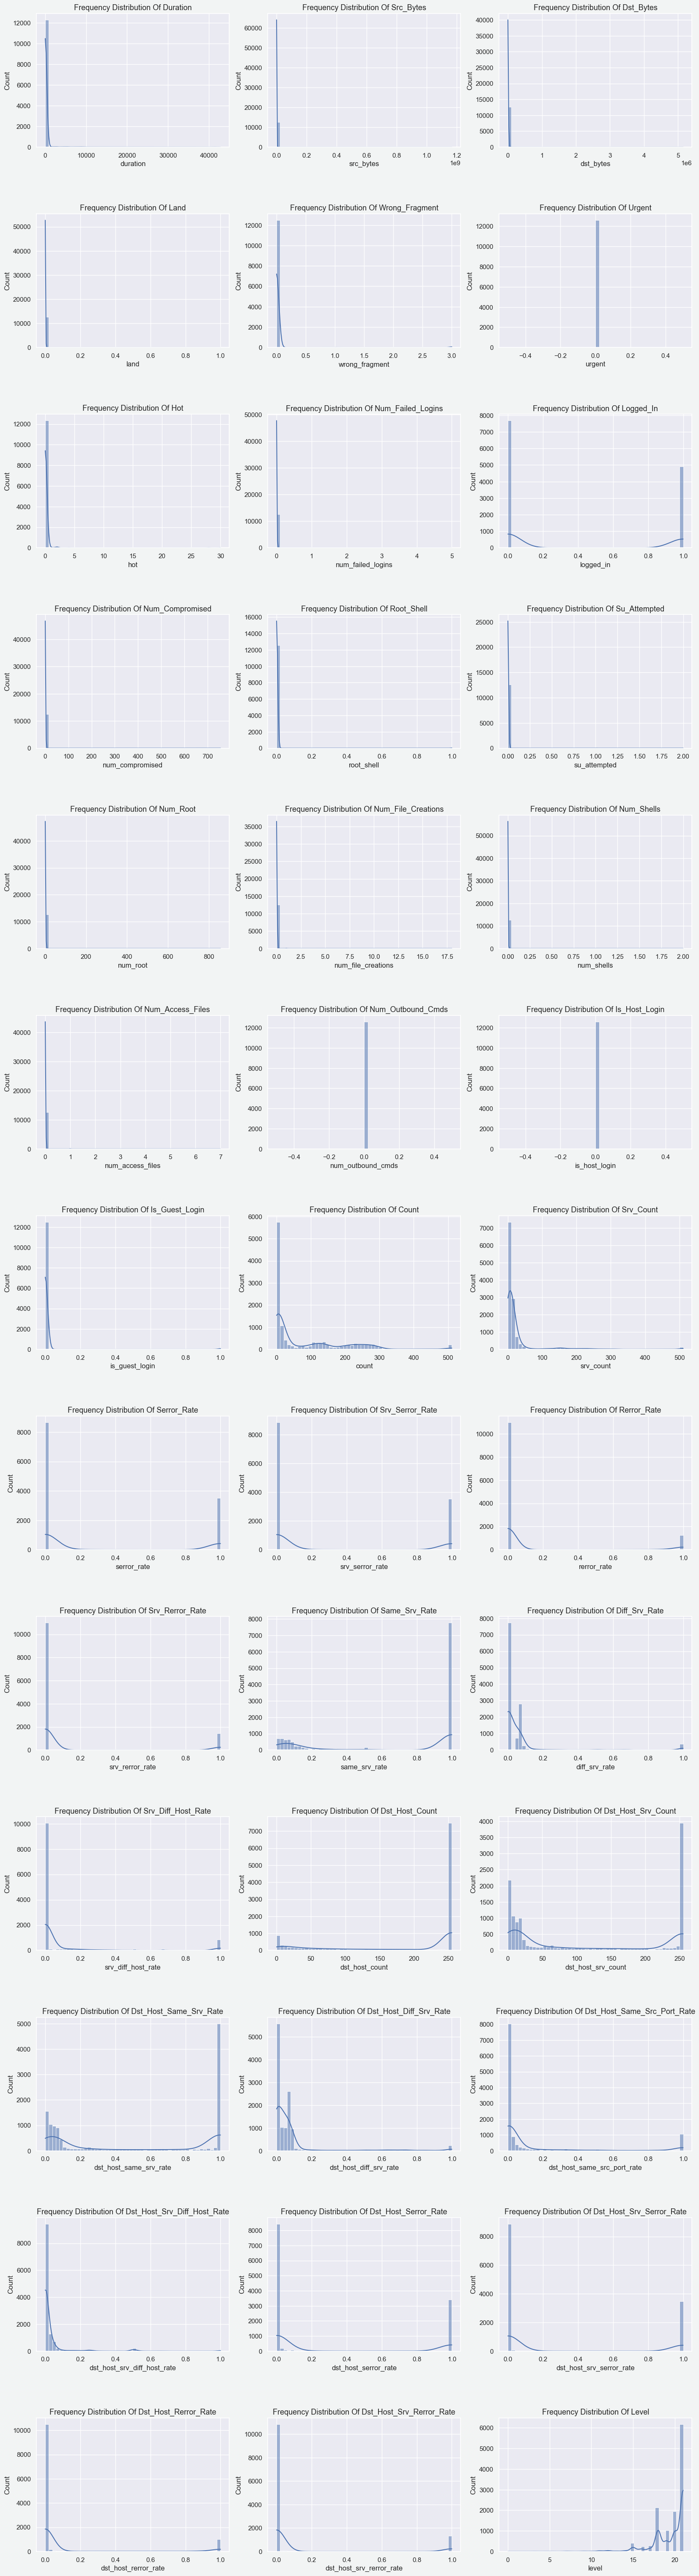

In [539]:
subsampled_data = train[numerical_features].sample(frac=0.1, random_state=42)

# Calculate the number of rows and columns for subplots
num_rows = (len(numerical_features) + 2) // 3  # Adjust the number of columns as needed
num_cols = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6), facecolor='#F2F4F4')
fig.subplots_adjust(wspace=0.2, hspace=0.5)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot histograms for each numerical feature
for i, feature in enumerate(numerical_features):
    h = sns.histplot(x=feature, kde=True, data=subsampled_data, bins=50, ax=axes[i])
    h.set_title(('Frequency Distribution of ' + feature).title(), fontsize=13)

# Remove any empty subplots if the number of features is not a multiple of 3
if len(numerical_features) % 3 != 0:
    for i in range(len(numerical_features), num_rows * num_cols):
        fig.delaxes(axes[i])

plt.show()

#### Categorical features

We identify categorical features and assign them to `categorical_features` variable.

In [540]:
categorical_features = [col for col in train.columns if train[col].dtype == "object" and col != 'xAttack']
print(categorical_features)

['protocol_type', 'service', 'flag']


<div style="border-radius:5px;border:#283149 solid;background-color:#FFFFFF; padding:20px; font-size:15px">
    
- Our data contains only 3 categorical features

In [541]:
cat = train[categorical_features]
cat.head()

,protocol_type,service,flag
0,udp,other,SF
1,tcp,private,S0
2,tcp,http,SF
3,tcp,http,SF
4,tcp,private,REJ


In [542]:
train.shape

(125972, 43)

We can then use count plots to understand the distribution of categorical data.

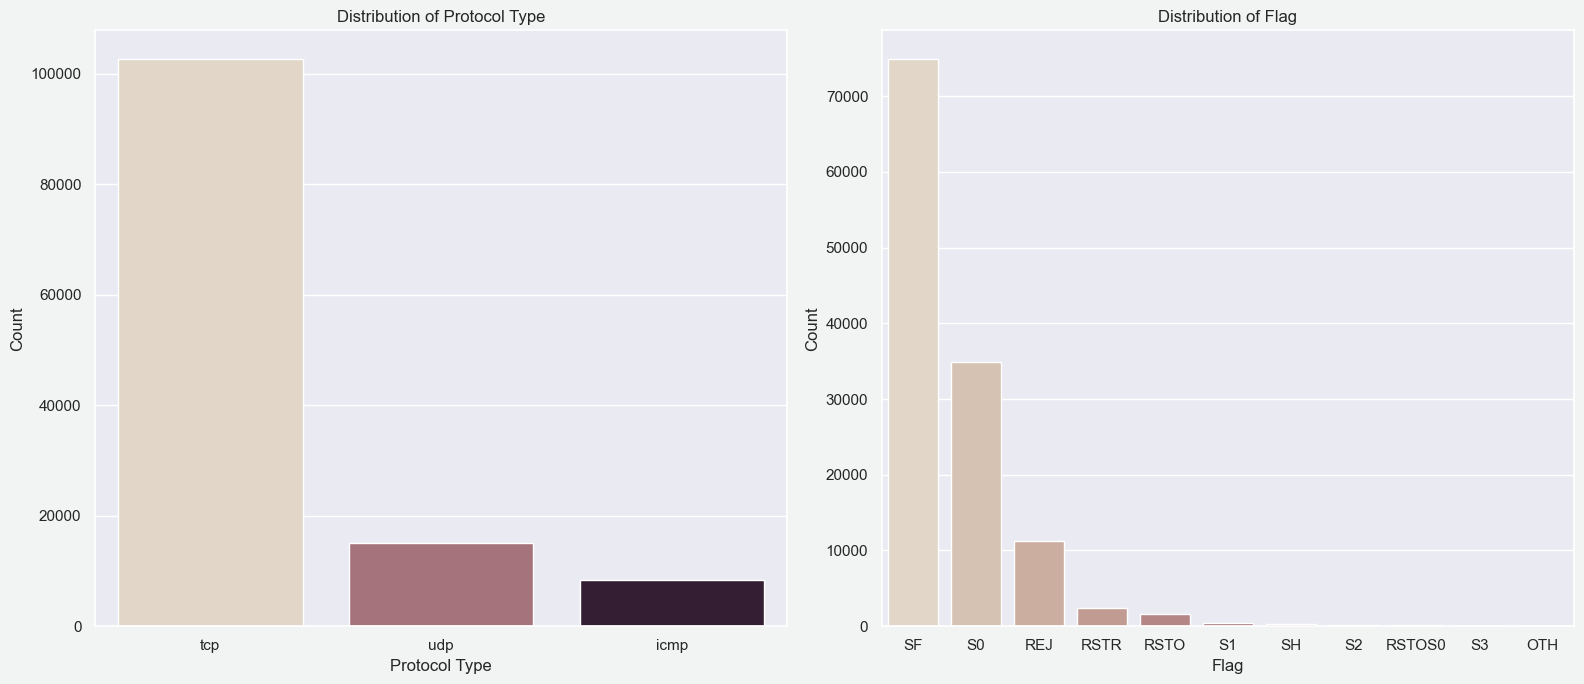

In [543]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 7), facecolor='#F2F4F4')

# Distribution of 'protocol_type'
sns.countplot(x='protocol_type', data=train, order=train['protocol_type'].value_counts().index, ax=axes[0], palette='ch:.25')
axes[0].set_title('Distribution of Protocol Type', fontsize=12)
axes[0].set_xlabel('Protocol Type')
axes[0].set_ylabel('Count')

# Distribution of 'flag'
sns.countplot(x='flag', data=train, order=train['flag'].value_counts().index, ax=axes[1], palette='ch:.25')
axes[1].set_title('Distribution of Flag', fontsize=12)
axes[1].set_xlabel('Flag')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

plt.show()


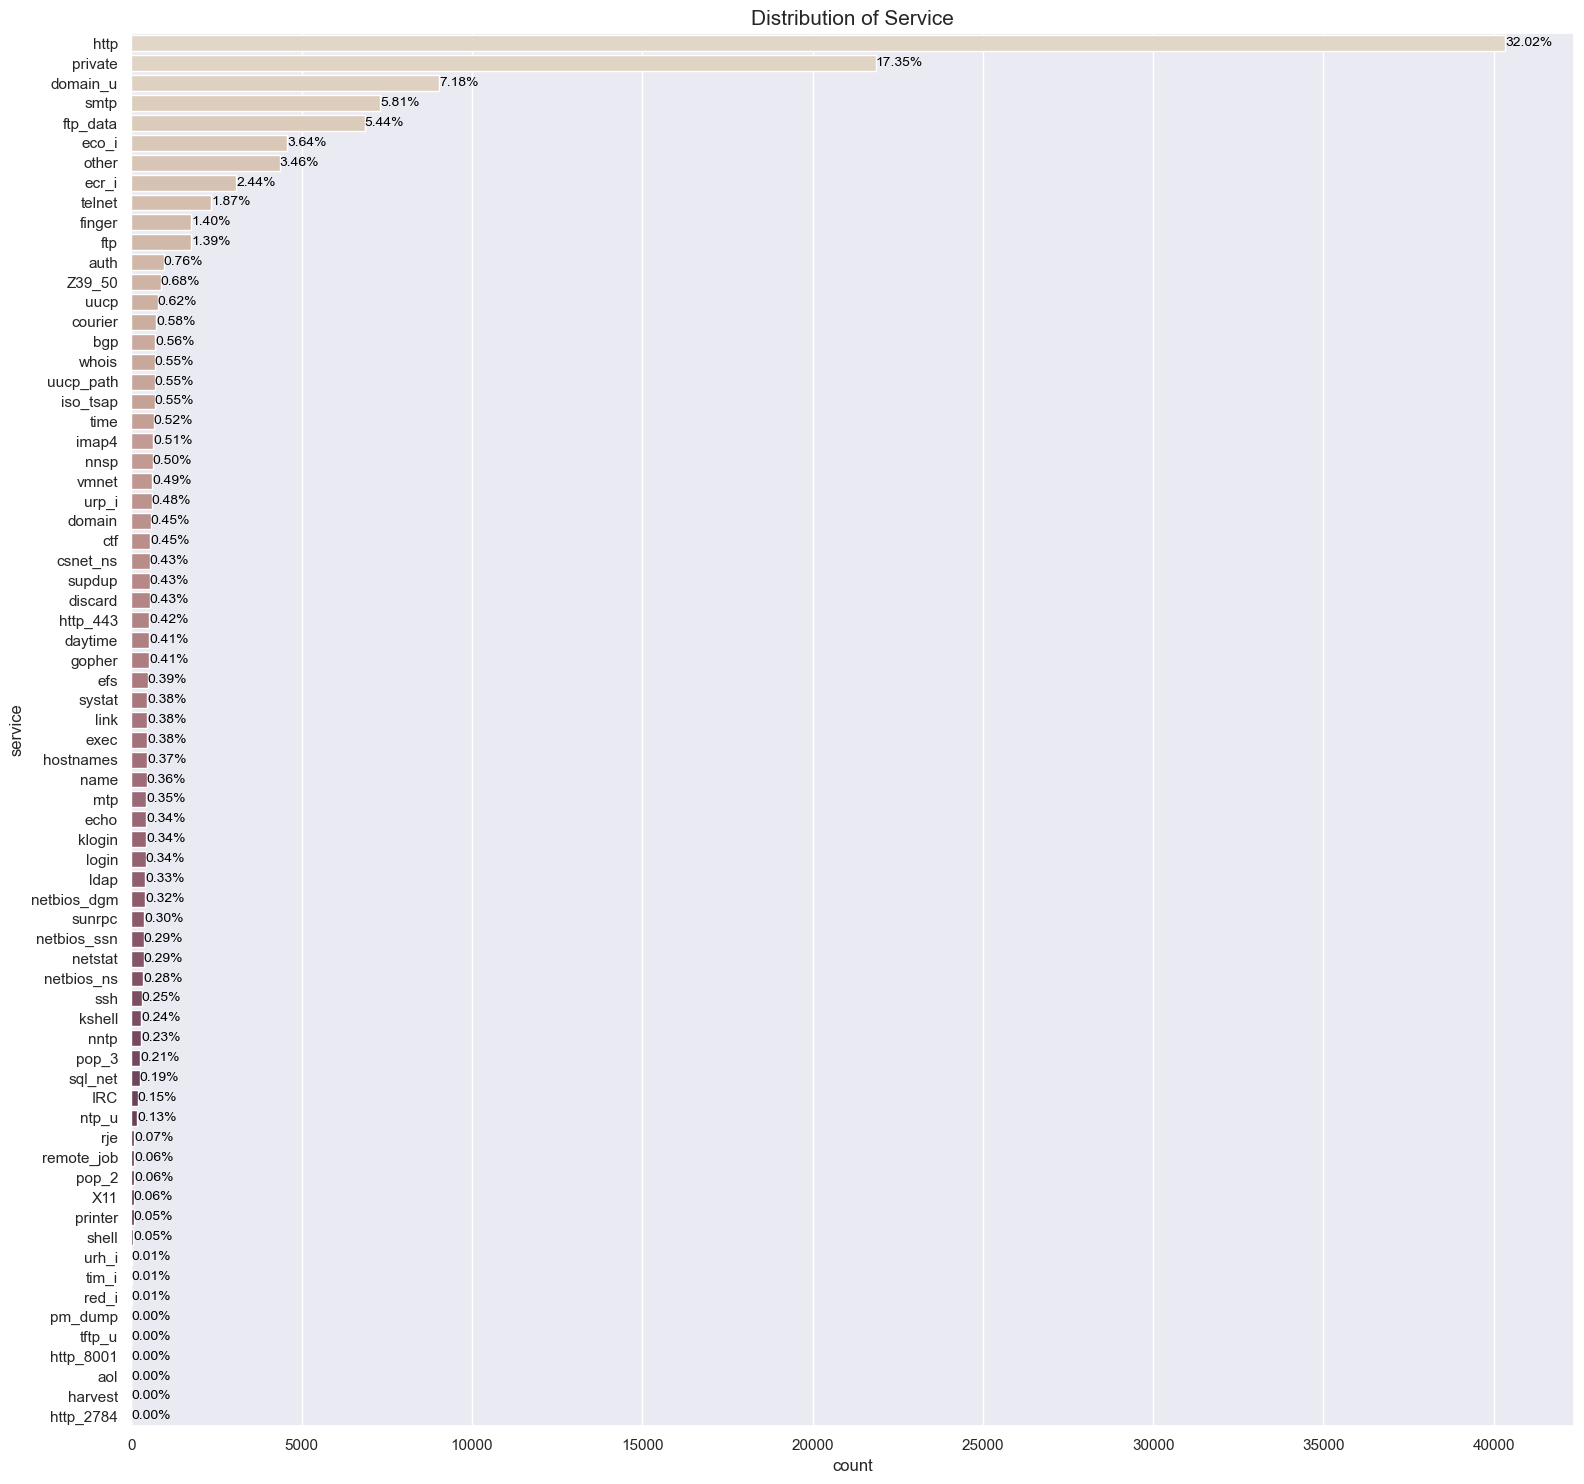

In [544]:
plt.figure(figsize=(16, 15))
sns.set_style('darkgrid')

# Distribution of 'service'
ax = sns.countplot(y='service', data=train, order=train['service'].value_counts().index, palette='ch:.25')

# Add percentage labels
total = len(train['service'])
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='left', va='center', fontsize=10, color='black')

# Set title and adjust layout
plt.title('Distribution of Service', fontsize=15)
plt.tight_layout()

plt.show()

## Data preprocessing

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">
In this step we have to analyze, filter, transform and encode data so that a machine learning algorithm can understand and work with the processed output.

### Handling missing data

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">
Missing values are a recurrent problem in real-world datasets because real-life data has physical and manual limitations.

We will identify missing values

In [545]:
missing_val_count_by_column = (train.isnull().sum())
columns_with_missing_values =  [col for col in train.columns
                     if train[col].isnull().any()]
columns_with_missing_values

[]

<div style="border-radius:5px;border:#283149 solid;background-color:#FFFFFF; padding:20px; font-size:15px">
    
- Our training data is already cleaned and doesn't contain any missing values.

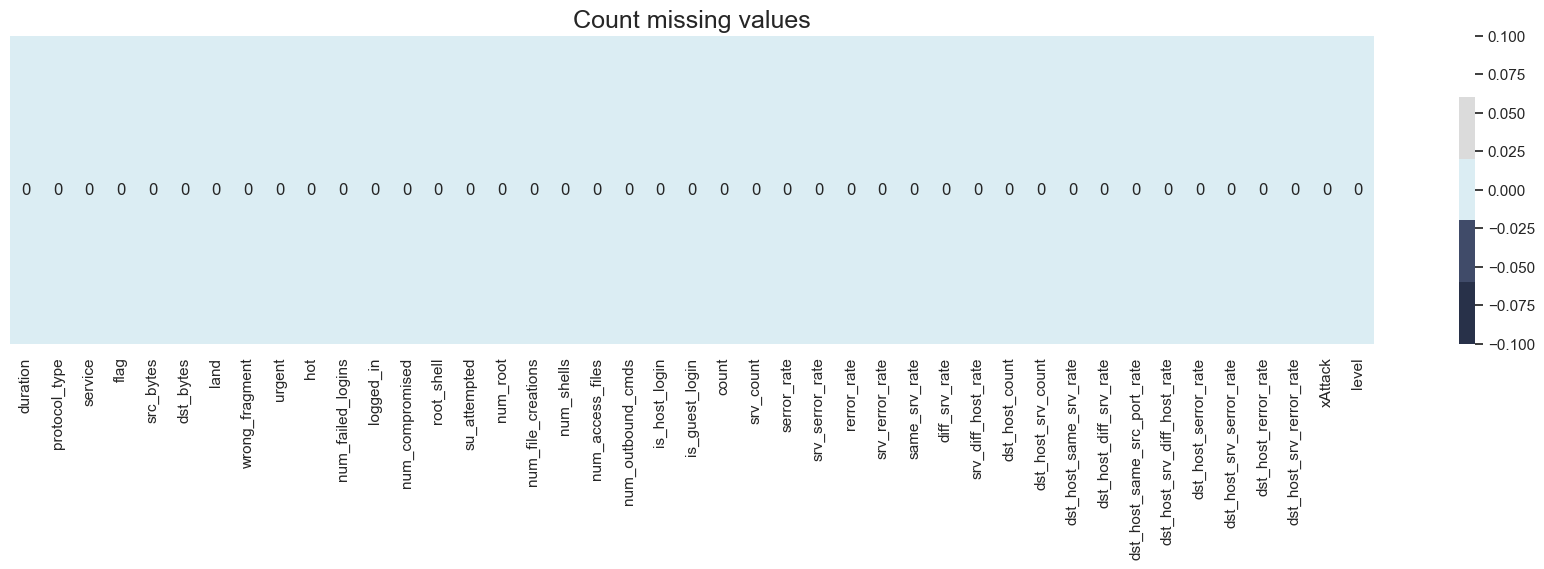

In [546]:
# Missing values
plt.figure(figsize=(22,4))
sns.heatmap((train.isna().sum()).to_frame(name='').T,cmap=sns.color_palette(["#283149", "#404B69", "#DBEDF3", "#DBDBDB", "#FFFFFF"]), annot=True,
             fmt='0.0f').set_title('Count missing values', fontsize=18)
plt.show()

### Duplicated Data

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">
    
📌**Duplicate data** refers to the presence of identical records in a dataset, which can distort the analysis and lead to incorrect conclusions. Removing duplicates is crucial for accurate analysis and modeling.

We will check our duplicated data.

In [547]:
# Duplicated data
train.duplicated().sum()

0

In [548]:
test.duplicated().sum()

0

### Exploring target "xAttack"

xAttack (label attribute) is classified into five categories 'normal', 'U2R', 'R2L', 'Probe', 'Dos'

we'll classify each of the attacks according to attack type for a more granular prediction model.
* Denial of Service attacks:
  * apache2
  * back
  * land
  * neptune
  * mailbomb
  * pod
  * processtable
  * smurf
  * teardrop
  * udpstorm
  * worm
* Probe attacks:
  * ipsweep
  * mscan
  * nmap
  * portsweep
  * saint
  * satan
* Privilege escalation attacks
  * buffer_overflow
  * loadmdoule
  * perl
  * ps
  * rootkit
  * sqlattack
  * xterm
* Remote access attacks
  * ftp_write
  * guess_passwd
  * http_tunnel
  * imap
  * multihop
  * named
  * phf
  * sendmail
  * snmpgetattack
  * snmpguess
  * spy
  * warezclient
  * warezmaster
  * xclock
  * xsnoop

Changing xAttack values to their respective attack class.

In [549]:
attack_mapping = {
    'neptune': 'DoS', 'back':'DoS', 'land': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS',
    'processtable': 'DoS', 'udpstorm': 'DoS', 'worm': 'DoS',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R',
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L',
    'warezmaster': 'R2L', 'sendmail': 'R2L', 'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L',
    'httptunnel': 'R2L',
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe', 'mscan': 'Probe', 'saint': 'Probe'
}
train['xAttack'] = train['xAttack'].replace(attack_mapping)
test['xAttack'] = test['xAttack'].replace(attack_mapping)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,DoS,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,DoS,21


Checking the distribution of attack families.

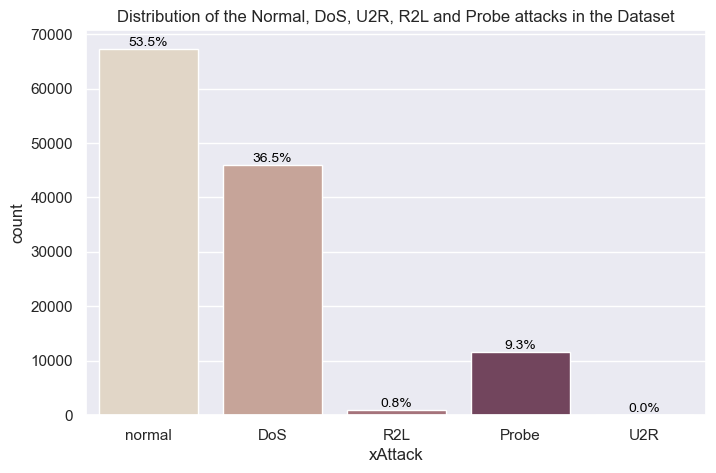

In [550]:
# Set the style and color palette
sns.set(style="darkgrid")
colors = sns.color_palette('pastel')

# Plot using Seaborn
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='xAttack', data=train, palette='ch:.25')

# Show percentages on top of the bars
total = len(train['xAttack'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of the Normal, DoS, U2R, R2L and Probe attacks in the Dataset')
plt.show()

<div style="border-radius:5px;border:#283149 solid;background-color:#FFFFFF; padding:20px; font-size:15px">
    
- We see that the normal attacks values are taking more than half of the xAttack features values.

We will Check the cardinality of the categorical features

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">
Cardinality refers to the number of different values in a variable. As we will create dummy variables from the categorical variables later on, we need to check whether there are variables with many distinct values. We should handle these variables differently as they would result in many dummy variables.

In [551]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: train[col].nunique(), categorical_features))
d = dict(zip(categorical_features, object_nunique))
# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('protocol_type', 3), ('flag', 11), ('service', 70)]

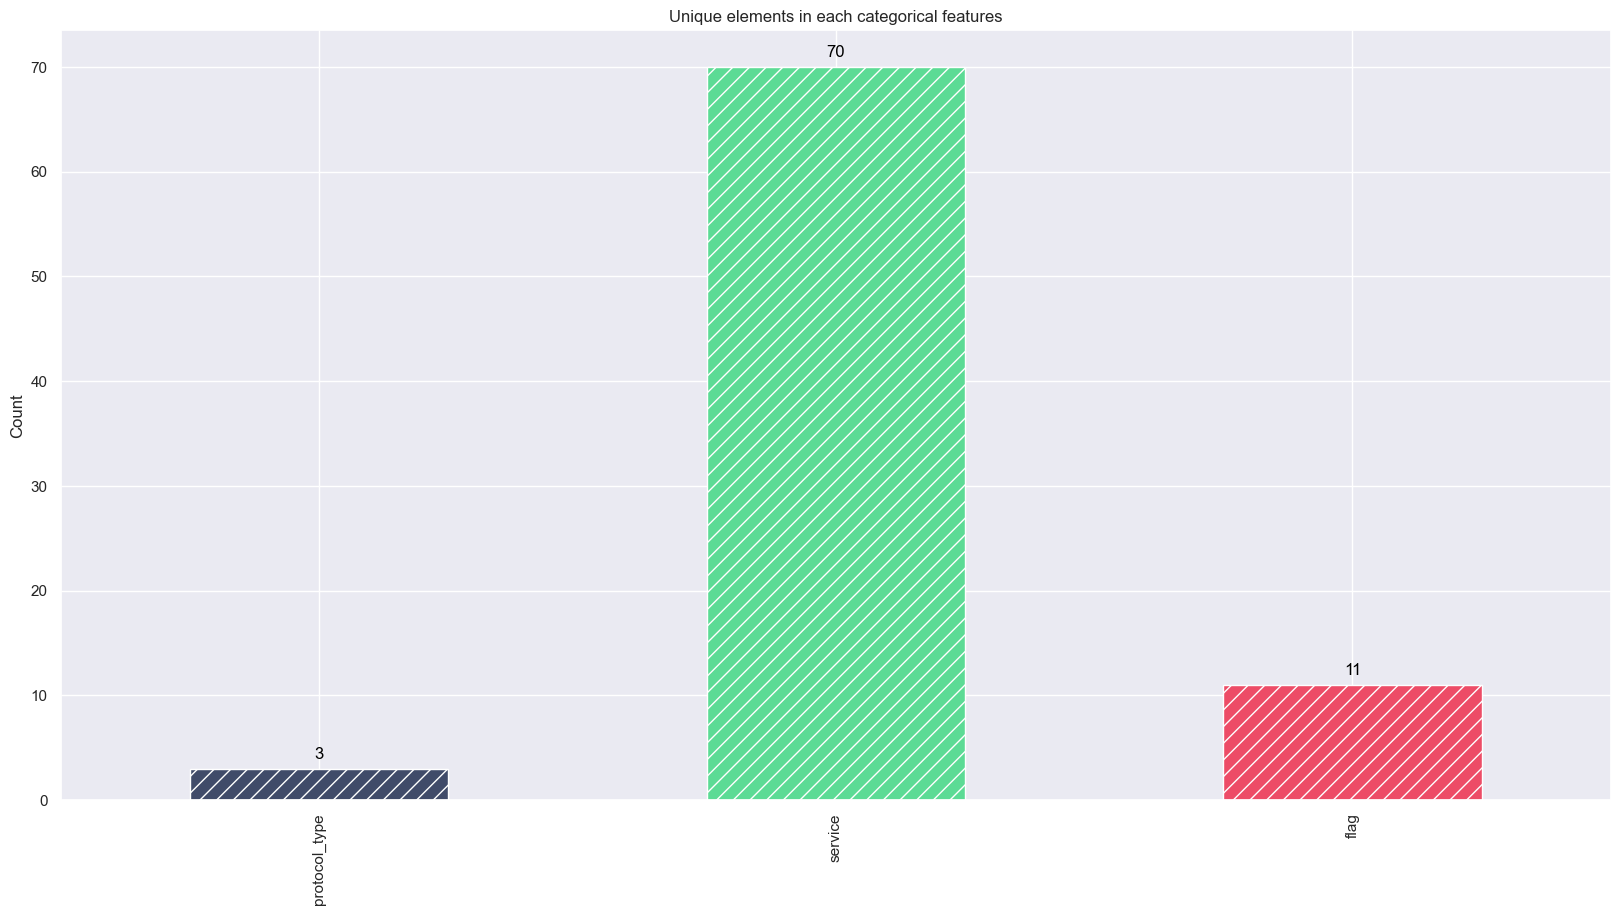

In [552]:
# Plot the unique values
unique = train[categorical_features].nunique()
plt.figure(figsize=(20, 10))
unique.plot(kind='bar', color=['#404B69', '#5CDB95', '#ED4C67', '#F7DC6F'], hatch='//')
plt.title('Unique elements in each categorical features')
plt.ylabel('Count')
for i, v in enumerate(unique.values):
    plt.text(i, v+1, str(v), color='black', ha='center')
plt.show()

### Univariate analysis

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">
In every technique which comes under the hood of Univariate Selection, every feature is individually studied and the relationship it shares with the target variable is taken into account.

We will see at first the distribution of the numerical values data using mean, median, Q1 and Q3.

In [ ]:
# Check variables distribution
data_num = train[numerical_features].sample(frac=0.1, random_state=42)

num_rows = (len(numerical_features) + 2) // 3  # Adjust the number of columns as needed
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(26, num_rows * 6))

# Define colors to use for each feature
colors = ["#283149"]

# Loop through each column and plot distribution
for i, column in enumerate(numerical_features):
    # Plot histogram with density curve
    sns.histplot(x=column, data=data_num, color=colors[i%1], ax=axes[i//2, i%2], kde=True)

    # Add vertical lines for mean, median, Q1 and Q3
    axes[i//2, i%2].axvline(x=train[column].median(), color='#e33434', linestyle='--', linewidth=2, label='Median')
    axes[i//2, i%2].axvline(x=train[column].quantile(0.25), color='orange', linestyle='--', linewidth=2, label='Q1')
    axes[i//2, i%2].axvline(x=train[column].quantile(0.75), color='#177ab0', linestyle='--', linewidth=2, label='Q3')

    # Add text box with important statistics
    median = train[column].median()
    q1 = train[column].quantile(0.25)
    q3 = train[column].quantile(0.75)
    iqr = q3 - q1
    axes[i//2, i%2].text(0.95, 0.95,
                          'Mean: {:.2f}\nMedian: {:.2f}\nQ1: {:.2f}\nQ3: {:.2f}\nIQR: {:.2f}\nMin: {:.2f}\nMax: {:.2f}'.format(
                              train[column].mean(), median, q1, q3, iqr, train[column].min(), train[column].max()),
                          transform=axes[i//2, i%2].transAxes,
                          fontsize=10, va='top', ha='right')

    # Add legend
    axes[i//2, i%2].legend(loc = "upper left")

    # Set title of subplot
    axes[i//2, i%2].set_title('Distribution of '+ column)

# Remove any empty subplots if the number of features is not a multiple of 3
if len(numerical_features) % 3 != 0:
    for i in range(len(numerical_features), num_rows * num_cols):
        fig.delaxes(axes[i])

# Add overall title and adjust spacing
fig.suptitle('Distribution of Numerical Variables', fontsize=16)
fig.tight_layout()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001AF3EAC4820> (for post_execute):

### Variance

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">
Variance is the measure of change in a given feature. For example, if all the samples in a feature have the same values, it would mean that the variance of that feature is zero. It’s essential to understand that a column which doesn’t have enough variance is as good as a column with all ‘nan’ or missing values. If there’s no change in the feature, it’s impossible to derive any pattern from it. So, we check the variance and eliminate any feature that shows low or no variation.

Variance thresholds might be a good way to eliminate features in datasets, but in cases where there are minority classes (say, 5% 0s and 95% 1s), even good features can have very low variance and still end up being very strong predictors. So, be advised – keep the target ratio in mind and use correlation methods before eliminating features solely based on variance.

#### Variance Thresholding
- Calculate the variance of each feature.
- Features with very low variance may not provide much information and can be dropped.

In [555]:
quantitative_data = train.select_dtypes(include='number')

In [556]:
quantitative_data.shape

(125972, 39)

In [557]:
from sklearn.feature_selection import VarianceThreshold
sel= VarianceThreshold(threshold=0.01)
sel.fit(quantitative_data)
mask=sel.get_support()
reduced_df = quantitative_data.loc[:,mask]
print(mask)
print(reduced_df.shape)

[ True  True  True False  True False  True False  True  True False False
  True  True False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
(125972, 29)


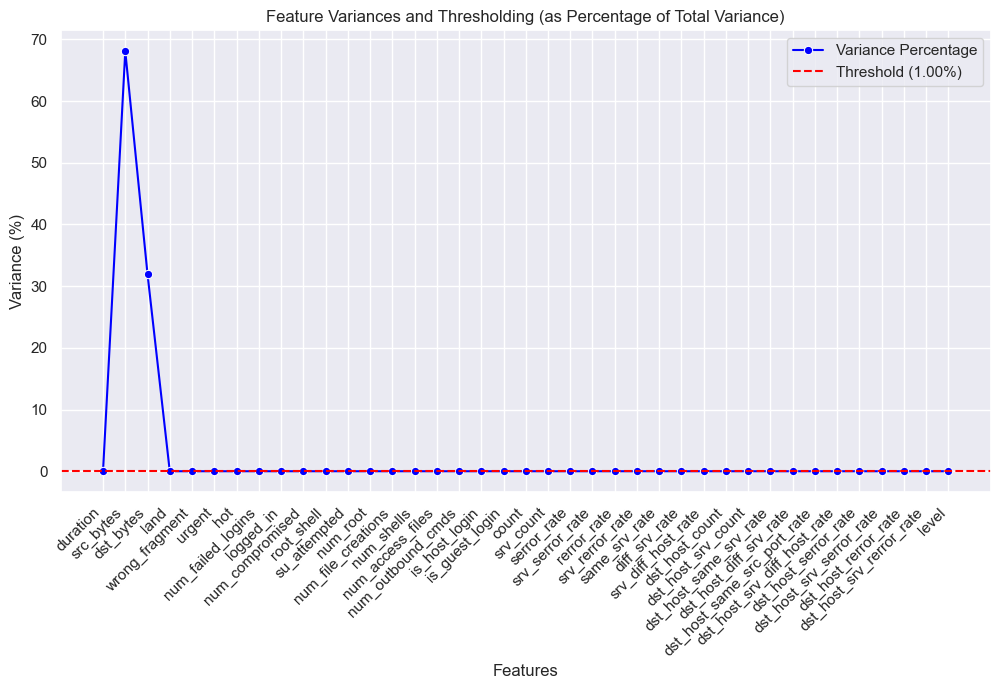

Columns that can be dropped based on variance threshold: Index(['land', 'urgent', 'num_failed_logins', 'root_shell', 'su_attempted',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login'],
      dtype='object')


In [558]:
feature_variances = sel.variances_

total_variance = sum(feature_variances)
feature_variances_percentage = (feature_variances / total_variance) * 100

plt.figure(figsize=(12, 6))
sns.lineplot(x=quantitative_data.columns, y=feature_variances_percentage, marker='o', color='blue', label='Variance Percentage', linestyle='-')

plt.axhline(y=0.01 / total_variance * 100, color='red', linestyle='--', label=f'Threshold ({0.01 * 100:.2f}%)')
plt.xlabel('Features')
plt.ylabel('Variance (%)')
plt.title('Feature Variances and Thresholding (as Percentage of Total Variance)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

columns_to_drop_variance = quantitative_data.columns[~sel.get_support()]
print("Columns that can be dropped based on variance threshold:", columns_to_drop_variance)

drop low variance features

In [559]:
reduced_df = pd.concat([reduced_df, train.select_dtypes(exclude=['number'])], axis=1)
train = reduced_df.copy()
train.shape

(125972, 33)

In [560]:
columns_to_keep = train.columns.tolist()
test = test[columns_to_keep]
test.shape

(22543, 33)

### Correlation

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">
Correlation is a univariate analysis technique. It detects linear relationships between two variables. Think of correlation as a measure of proportionality, which simply measures how the increase or decrease of a variable affects the other variable.

#### Finding Correlation among Features

Correlation Heatmap

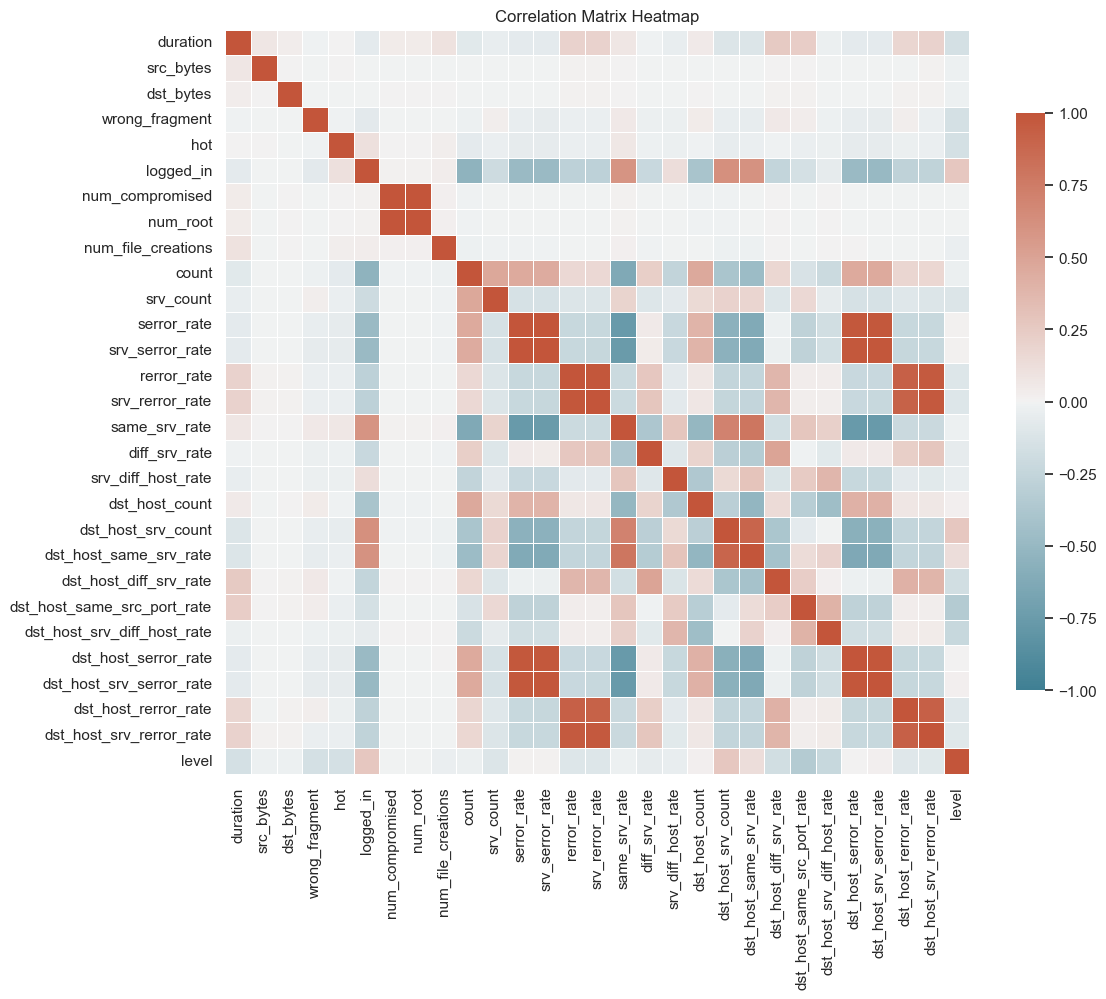

In [561]:
corr = train.corr()
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .75})
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Correlation Analysis:
- Calculate the correlation matrix for our features.
- Identify pairs of highly correlated features.
- If two features are highly correlated, you might consider keeping only one of them.

In [562]:
plt.figure(figsize=(40,35))
corr_df = train.corr().abs()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
to_drop = [c for c in tri_df.columns if any(tri_df[c] >=  0.9)]

print("Columns that can be dropped using correlation:",to_drop)


Columns that can be dropped using correlation: ['num_compromised', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_rerror_rate']


<Figure size 4000x3500 with 0 Axes>

Drop high correlation features

In [563]:
train = train.drop(columns=to_drop, axis=1)
test = test.drop(columns=to_drop, axis=1)

In [564]:
train.shape

(125972, 26)

In [565]:
test.shape

(22543, 26)

# Binary Classification

In [566]:
attack_n = []
for i in train.xAttack :
  if i == 'normal':
    attack_n.append("normal")
  else:
    attack_n.append("attack")
train['xAttack'] = attack_n

In [567]:
attack_n = []
for i in test.xAttack :
  if i == 'normal':
    attack_n.append("normal")
  else:
    attack_n.append("attack")
test['xAttack'] = attack_n

In [568]:
train['xAttack']

0         normal
1         attack
2         normal
3         normal
4         attack
           ...  
125967    attack
125968    normal
125969    normal
125970    attack
125971    normal
Name: xAttack, Length: 125972, dtype: object

In [569]:
test['xAttack']

0        attack
1        normal
2        attack
3        attack
4        normal
          ...  
22538    normal
22539    normal
22540    attack
22541    normal
22542    attack
Name: xAttack, Length: 22543, dtype: object

We will encode our binary labels using LabelEncoder:
- normal: 0
- abnormal: 1

In [570]:
train.loc[train['xAttack'] == "normal", "xAttack"] = 0
train.loc[train['xAttack']!= 0, "xAttack"] = 1

In [571]:
train['xAttack']

0         0
1         1
2         0
3         0
4         1
         ..
125967    1
125968    0
125969    0
125970    1
125971    0
Name: xAttack, Length: 125972, dtype: object

In [572]:
x_train = train.drop(['xAttack', 'level'] , axis = 1)
y_train= train['xAttack']
y_train = y_train.astype('int')
x_train = train.select_dtypes(include='number')


In [573]:
test.loc[test['xAttack'] == "normal", "xAttack"] = 0
test.loc[test['xAttack']!= 0, "xAttack"] = 1

In [574]:
test['xAttack']

0        1
1        0
2        1
3        1
4        0
        ..
22538    0
22539    0
22540    1
22541    0
22542    1
Name: xAttack, Length: 22543, dtype: object

We visualize a pie chart to see the distribution of normal and abnormal labels of our binary data.

*   Our dataset is balanced. The normal and abnormal value percentages are close.




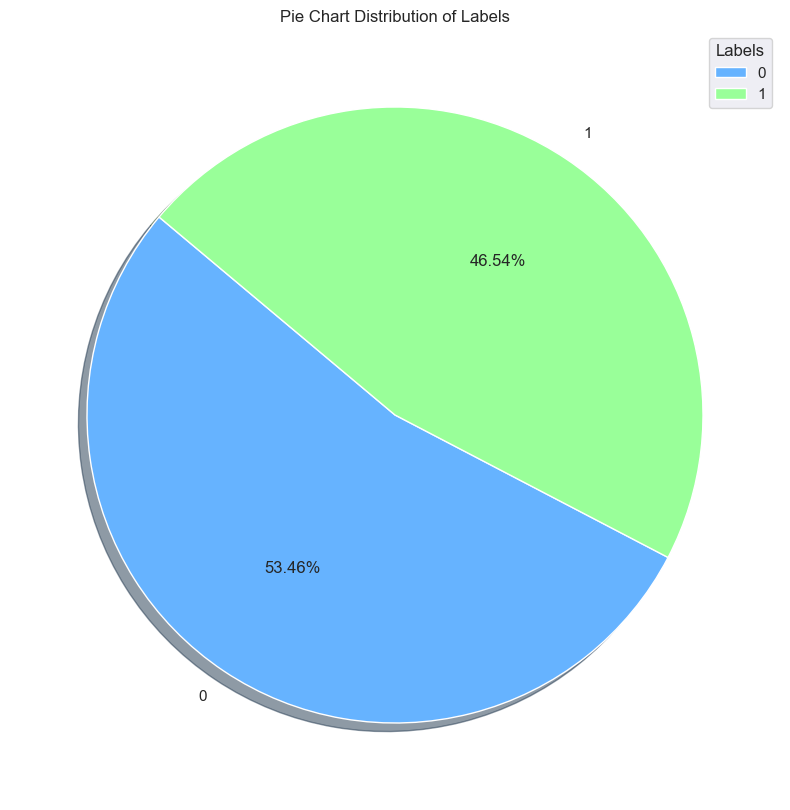

In [575]:
label_counts = train.xAttack.value_counts()

colors = ['#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

plt.figure(figsize=(10, 10))
plt.pie(label_counts, labels=label_counts.index, autopct='%0.2f%%', colors=colors, shadow=True, startangle=140)

plt.title("Pie Chart Distribution of Labels")
plt.legend(title="Labels", loc="upper right")
plt.show()

### Chi-Square

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">
Chi-square is a statistical tool, or test, which can be used on groups of categorical features to evaluate the likelihood of association, or correlation, with the help of frequency distributions.

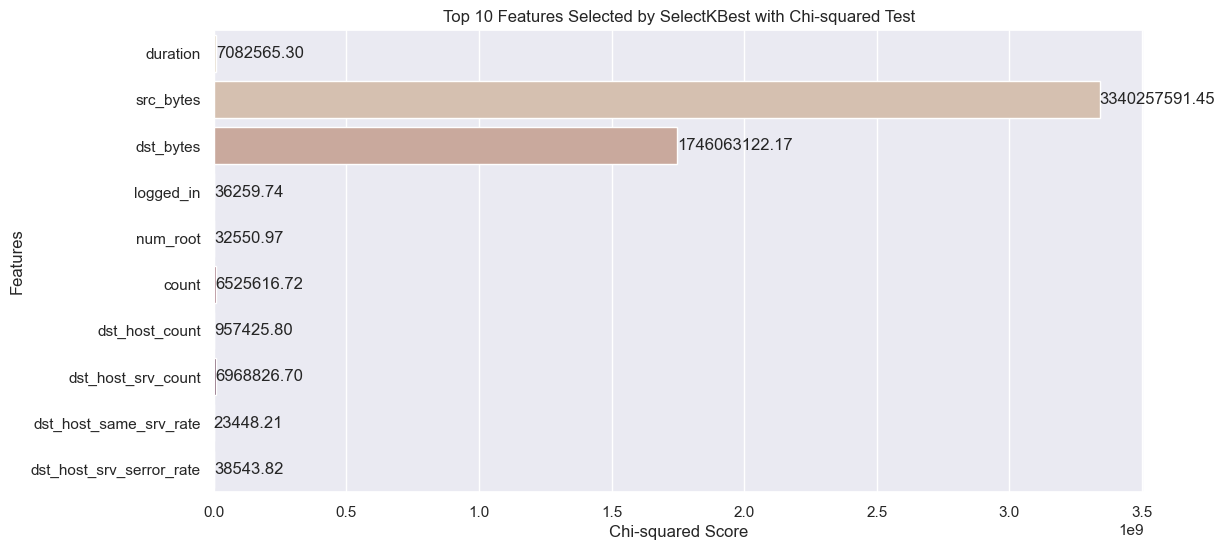

In [576]:
selector = SelectKBest(chi2, k=10)

selector.fit(x_train, y_train)

selected_features = train.columns[selector.get_support(indices=True)]
feature_scores = selector.scores_[selector.get_support(indices=True)]

plt.figure(figsize=(12, 6))
bar_colors = sns.color_palette("ch:.25", n_colors=len(selected_features))
sns.barplot(x=feature_scores, y=selected_features, palette=bar_colors)

for idx, score in enumerate(feature_scores):
    plt.text(score + 0.02, idx, f'{score:.2f}', ha='left', va='center')

plt.xlabel('Chi-squared Score')
plt.ylabel('Features')
plt.title('Top 10 Features Selected by SelectKBest with Chi-squared Test')
plt.show()

Logistic Regression

In [577]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

lr.fit(x_train, y_train)
dict(zip(x_train.columns,abs(lr.coef_[0])))

C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'duration': 5.898405272806575e-06,
 'src_bytes': 1.3216123693544387e-08,
 'dst_bytes': 1.0379357324719198e-07,
 'wrong_fragment': 6.83135350847031e-06,
 'hot': 1.3391778782941792e-05,
 'logged_in': 8.605670080912729e-05,
 'num_root': 0.00011428059796518137,
 'num_file_creations': 4.511153177629781e-06,
 'count': 0.012816035518707884,
 'srv_count': 0.0008454655960544478,
 'same_srv_rate': 8.678320662345137e-05,
 'diff_srv_rate': 5.948542109943155e-06,
 'srv_diff_host_rate': 4.2135040187900305e-06,
 'dst_host_count': 0.003816888341834039,
 'dst_host_srv_count': 0.019126334621502573,
 'dst_host_same_srv_rate': 7.303088750931407e-05,
 'dst_host_diff_srv_rate': 7.236320572696516e-06,
 'dst_host_same_src_port_rate': 8.376789872292382e-06,
 'dst_host_srv_diff_host_rate': 3.820942860003518e-06,
 'dst_host_srv_serror_rate': 6.349929589763937e-05,
 'dst_host_srv_rerror_rate': 1.6701373773687777e-05,
 'level': 0.0006049114920282606}

In [578]:
from sklearn.feature_selection import RFE
rfe=RFE(estimator=LogisticRegression(),n_features_to_select=2,verbose=1)
rfe.fit(x_train, y_train)

Fitting estimator with 22 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 21 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 20 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 19 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 18 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 17 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 16 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 15 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 14 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 13 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 12 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 11 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 10 features.


C:\Users\Montassar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.


RFE(estimator=LogisticRegression(), n_features_to_select=2, verbose=1)

In [579]:
dict(zip(x_train.columns,rfe.ranking_))

{'duration': 19,
 'src_bytes': 21,
 'dst_bytes': 20,
 'wrong_fragment': 2,
 'hot': 14,
 'logged_in': 7,
 'num_root': 11,
 'num_file_creations': 10,
 'count': 15,
 'srv_count': 16,
 'same_srv_rate': 1,
 'diff_srv_rate': 6,
 'srv_diff_host_rate': 13,
 'dst_host_count': 18,
 'dst_host_srv_count': 17,
 'dst_host_same_srv_rate': 8,
 'dst_host_diff_srv_rate': 12,
 'dst_host_same_src_port_rate': 4,
 'dst_host_srv_diff_host_rate': 1,
 'dst_host_srv_serror_rate': 3,
 'dst_host_srv_rerror_rate': 5,
 'level': 9}

Drop flag,serivce,protocol feature

In [588]:
train = train.drop(columns= ['flag','service','protocol_type'], axis=1)
test = test.drop(columns= ['flag','service','protocol_type'], axis=1)

In [589]:
train.shape

(125972, 23)

In [590]:
test.shape

(22543, 23)

## Outliers

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">
    
📌Investigating **Outliers** is an essential step in data analysis because they can significantly affect the statistical measures used to describe a dataset. Outliers are observations that differ significantly from other observations in the same dataset and can result from measurement errors, sampling issues, or genuine differences in the population. Identifying and dealing with outliers can help to improve the accuracy and reliability of statistical models and results, leading to more informed decisions and better outcomes. Therefore, outlier investigation is a crucial step in any data analysis process.

Before we define outliers, we will need to drop protocol_type feature since it's a categorical feature.

Then, we us a boxplot to identify outliers within each column.

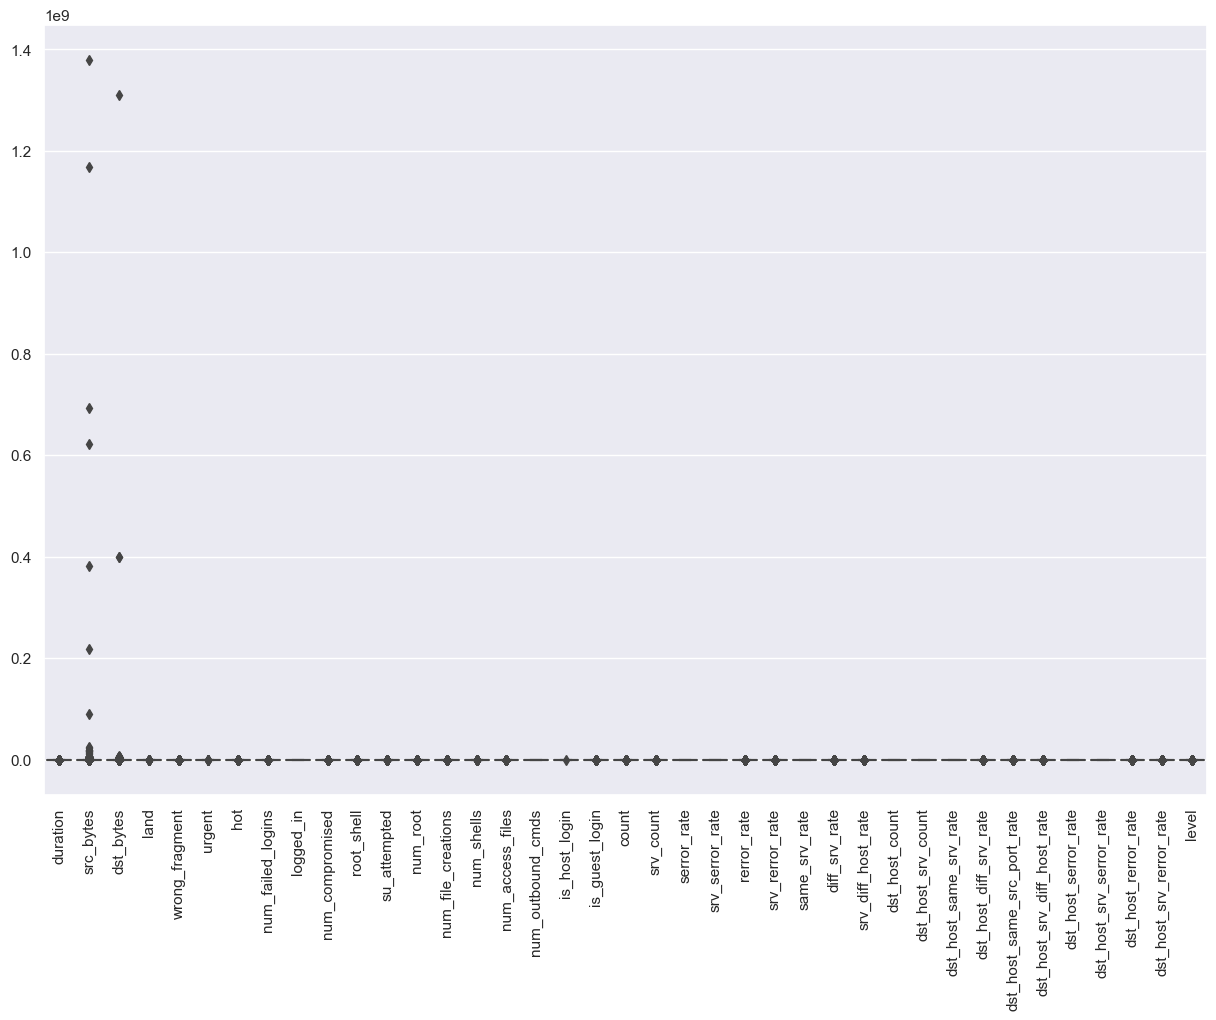

In [581]:
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')
sns.boxplot(data=quantitative_data)
plt.xticks(rotation=90)
plt.show()

We also defined boxplots to define outliers seperately within each column

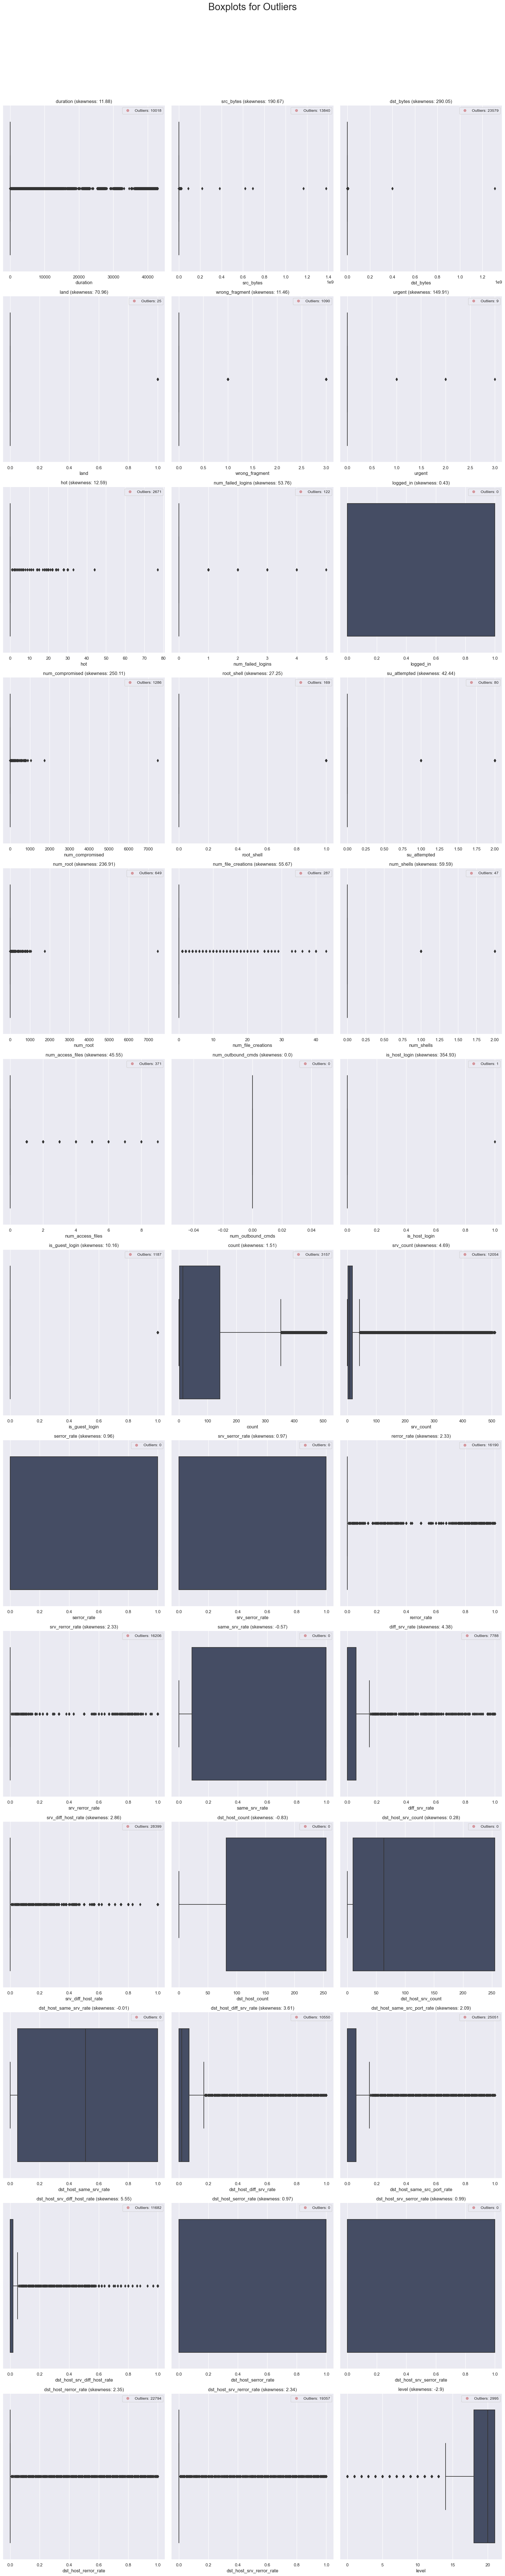

In [582]:
def plot_numerical_features_boxplots(data, columns_list, title):
    num_features = len(columns_list)
    cols = 3
    rows = (num_features + cols - 1) // cols

    sns.set_style('darkgrid')
    fig, axs = plt.subplots(rows, cols, figsize=(18, 7 * rows), sharey=True)
    fig.suptitle(title, fontsize=25, y=1)

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    axs = axs.flatten()

    # Initialize an empty DataFrame to collect outliers
    outliers_df = pd.DataFrame(columns=['Column', 'Outlier_index', 'Outlier_values'])

    for i, col in enumerate(columns_list):
        sns.boxplot(x=data[col], color='#404B69', ax=axs[i])
        axs[i].set_title(f'{col} (skewness: {round(float(data[col].skew()), 2)})', fontsize=12)

        #----------------------------
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR)))
        outliers_index = data[outliers].index.tolist()
        outliers_values = data[col][outliers].tolist()

        # Append outliers to the DataFrame
        outliers_df = pd.concat([outliers_df, pd.DataFrame({'Column': [col], 'Outlier_index': [outliers_index], 'Outlier_values': [outliers_values]})], ignore_index=True)

        axs[i].plot([], [], 'ro', alpha=0.5, label=f'Outliers: {outliers.sum()}')
        axs[i].legend(loc='upper right', fontsize=10)

    # Hide empty subplots (if any)
    for i in range(num_features, rows * cols):
        axs[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout
    return outliers_df

# Example usage
outliers_df_result = plot_numerical_features_boxplots(data=quantitative_data, columns_list=quantitative_data.columns, title='Boxplots for Outliers')


We defined blow functions to remove outliers from both training and test sets. But they are momental until we define better functions to deal with outliers.

In [59]:
# Function to identify and remove outliers based on IQR
def remove_outliers(data, k=1.5):
    outliers = pd.DataFrame()
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        column_outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outliers = pd.concat([outliers, column_outliers])

    return outliers

# Identify and remove outliers
outliers = remove_outliers(quantitative_data)
quantitative_data = quantitative_data[~quantitative_data.index.isin(outliers.index)]

# Display the first few rows of the dataset without outliers
#filtered_data_no_outliers.head()

In [62]:
filtered_data_no_outliers = quantitative_data.loc[:, (quantitative_data != 0).any(axis=0)]
filtered_data_no_outliers.columns

Index(['src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'diff_srv_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'level'],
      dtype='object')

duration feature was an important feature in chi-squared and Logistic regression

In [64]:
train.head(10)

,duration,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_root,num_file_creations,count,srv_count,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,dst_host_srv_rerror_rate,level,protocol_type,xAttack
0,0,491,0,0,0,0,0,0,2,2,...,25,0.17,0.03,0.17,0.00,0.00,0.00,20,tcp,0
1,0,146,0,0,0,0,0,0,13,1,...,1,0.00,0.60,0.88,0.00,0.00,0.00,15,udp,0
2,0,0,0,0,0,0,0,0,123,6,...,26,0.10,0.05,0.00,0.00,1.00,0.00,19,tcp,1
3,0,232,8153,0,0,1,0,0,5,5,...,255,1.00,0.00,0.03,0.04,0.01,0.01,21,tcp,0
4,0,199,420,0,0,1,0,0,30,32,...,255,1.00,0.00,0.00,0.00,0.00,0.00,21,tcp,0
5,0,0,0,0,0,0,0,0,121,19,...,19,0.07,0.07,0.00,0.00,0.00,1.00,21,tcp,1
6,0,0,0,0,0,0,0,0,166,9,...,9,0.04,0.05,0.00,0.00,1.00,0.00,21,tcp,1
7,0,0,0,0,0,0,0,0,117,16,...,15,0.06,0.07,0.00,0.00,1.00,0.00,21,tcp,1
8,0,0,0,0,0,0,0,0,270,23,...,23,0.09,0.05,0.00,0.00,1.00,0.00,21,tcp,1
9,0,0,0,0,0,0,0,0,133,8,...,13,0.05,0.06,0.00,0.00,1.00,0.00,21,tcp,1


In [65]:
test.head(10)

,duration,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_root,num_file_creations,count,srv_count,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,dst_host_srv_rerror_rate,level,protocol_type,xAttack
0,0,0,0,0,0,0,0,0,229,10,...,10,0.04,0.06,0.00,0.00,0.00,1.00,21,tcp,DoS
1,0,0,0,0,0,0,0,0,136,1,...,1,0.00,0.06,0.00,0.00,0.00,1.00,21,tcp,DoS
2,2,12983,0,0,0,0,0,0,1,1,...,86,0.61,0.04,0.61,0.02,0.00,0.00,21,tcp,normal
3,0,20,0,0,0,0,0,0,1,65,...,57,1.00,0.00,1.00,0.28,0.00,0.00,15,icmp,Probe
4,1,0,15,0,0,0,0,0,1,8,...,86,0.31,0.17,0.03,0.02,0.00,0.71,11,tcp,Probe
5,0,267,14515,0,0,1,0,0,4,4,...,255,1.00,0.00,0.01,0.03,0.00,0.00,21,tcp,normal
6,0,1022,387,0,0,1,0,0,1,3,...,28,0.11,0.72,0.00,0.00,0.00,0.04,21,tcp,normal
7,0,129,174,0,0,0,0,0,1,1,...,255,1.00,0.00,0.00,0.00,0.01,0.02,15,tcp,R2L
8,0,327,467,0,0,1,0,0,33,47,...,255,1.00,0.00,0.01,0.03,0.00,0.00,21,tcp,normal
9,0,26,157,0,0,0,0,0,1,1,...,26,0.50,0.08,0.02,0.00,0.00,0.00,7,tcp,R2L


# Generating datasets

## d_raw

The original NSL dataset without any transformation of the numerical values.

In [591]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   src_bytes                    125972 non-null  int64  
 2   dst_bytes                    125972 non-null  int64  
 3   wrong_fragment               125972 non-null  int64  
 4   hot                          125972 non-null  int64  
 5   logged_in                    125972 non-null  int64  
 6   num_root                     125972 non-null  int64  
 7   num_file_creations           125972 non-null  int64  
 8   count                        125972 non-null  int64  
 9   srv_count                    125972 non-null  int64  
 10  same_srv_rate                125972 non-null  float64
 11  diff_srv_rate                125972 non-null  float64
 12  srv_diff_host_rate           125972 non-null  float64
 13 

In [592]:
d_raw_train = train.copy()
d_raw_test = test.copy()

In [593]:
d_raw_train.shape

(125972, 23)

In [284]:
train_target = d_raw_train['xAttack']
train_target = train_target.astype('int')
d_raw_train= d_raw_train.drop('xAttack',axis=1)

test_target = d_raw_test['xAttack']
test_target= test_target.astype('int')
d_raw_test= d_raw_test.drop('xAttack',axis=1)

In [285]:
train_target

0         0
1         1
2         0
3         0
4         1
         ..
125967    1
125968    0
125969    0
125970    1
125971    0
Name: xAttack, Length: 125972, dtype: int32

In [286]:
test_target

0        1
1        0
2        1
3        1
4        0
        ..
22538    0
22539    0
22540    1
22541    0
22542    1
Name: xAttack, Length: 22543, dtype: int32

In [594]:
d_raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   src_bytes                    125972 non-null  int64  
 2   dst_bytes                    125972 non-null  int64  
 3   wrong_fragment               125972 non-null  int64  
 4   hot                          125972 non-null  int64  
 5   logged_in                    125972 non-null  int64  
 6   num_root                     125972 non-null  int64  
 7   num_file_creations           125972 non-null  int64  
 8   count                        125972 non-null  int64  
 9   srv_count                    125972 non-null  int64  
 10  same_srv_rate                125972 non-null  float64
 11  diff_srv_rate                125972 non-null  float64
 12  srv_diff_host_rate           125972 non-null  float64
 13 

In [595]:
d_raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22543 entries, 0 to 22542
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22543 non-null  int64  
 1   src_bytes                    22543 non-null  int64  
 2   dst_bytes                    22543 non-null  int64  
 3   wrong_fragment               22543 non-null  int64  
 4   hot                          22543 non-null  int64  
 5   logged_in                    22543 non-null  int64  
 6   num_root                     22543 non-null  int64  
 7   num_file_creations           22543 non-null  int64  
 8   count                        22543 non-null  int64  
 9   srv_count                    22543 non-null  int64  
 10  same_srv_rate                22543 non-null  float64
 11  diff_srv_rate                22543 non-null  float64
 12  srv_diff_host_rate           22543 non-null  float64
 13  dst_host_count  

In [596]:
d_raw_train['xAttack'] = train_target
d_raw_train_normal = d_raw_train[d_raw_train['xAttack'] == 0]
d_raw_train_normal.drop(['xAttack'], inplace=True, axis = 1)
d_raw_train.drop(['xAttack'], inplace=True, axis = 1)
d_raw_train_normal.head()

C:\Users\Montassar\AppData\Local\Temp\ipykernel_25992\71015043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_raw_train_normal.drop(['xAttack'], inplace=True, axis = 1)


,duration,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_root,num_file_creations,count,srv_count,...,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,dst_host_srv_rerror_rate,level
0,0,146,0,0,0,0,0,0,13,1,...,0.00,255,1,0.0,0.6,0.88,0.00,0.00,0.00,15
2,0,232,8153,0,0,1,0,0,5,5,...,0.00,30,255,1.0,0.0,0.03,0.04,0.01,0.01,21
3,0,199,420,0,0,1,0,0,30,32,...,0.09,255,255,1.0,0.0,0.00,0.00,0.00,0.00,21
11,0,287,2251,0,0,1,0,0,3,7,...,0.43,8,219,1.0,0.0,0.12,0.03,0.00,0.00,21
15,0,300,13788,0,0,1,0,0,8,9,...,0.22,91,255,1.0,0.0,0.01,0.02,0.00,0.00,21


## d_raw_probs

We apply the FGMPM to the original NSL dataset values and change each feature value for the occurrence probability of each feature in the normal model.

In [290]:
def GMM_Row_Transform(data, values, threshold):
    probs = []
    for idx in range(len(data.columns)):
        mean = np.array(data.iloc[:,idx]).mean()
        std = np.array(data.iloc[:,idx]).std()

        z_score = (values[idx] - mean)/std
        prob = (1-norm.cdf(z_score))*100
        probs.append(prob)
    return probs

In [291]:
def GMM_Matrix_Transform(origin_data, data, threshold):
    matrix = []
    for i in tqdm(range(len(data))):
        row = GMM_Row_Transform(origin_data, data.iloc[i,:], threshold)

        matrix.append(row)
    return matrix

In [292]:
def gmm_transform(data):
    gmm_transformed = []

    for i in tqdm(range(len(data))):
        row = []
        for idx in range(len(data[i])):
            mean = np.array(data[:, idx]).mean()
            std = np.array(data[:, idx]).std()
            z_score = (data[i, idx] - mean) / std
            prob = (1 - norm.cdf(z_score)) * 100
            row.append(prob)
        gmm_transformed.append(row)

    return np.array(gmm_transformed)

In [293]:
def GMM_vote(data, values, threshold):
    no = 0
    for idx in range(len(data.columns)):
        mean = np.array(data.iloc[:,idx]).mean()
        std = np.array(data.iloc[:,idx]).std()

        z_score = (values[idx] - mean)/std
        prob = (1-norm.cdf(z_score))*100
        if prob <= threshold:
            no += 1
    return no

In [294]:
d_raw_probs_train = pd.DataFrame(GMM_Matrix_Transform(d_raw_train, d_raw_train, 50))
d_raw_probs_test =  pd.DataFrame(GMM_Matrix_Transform(d_raw_train, d_raw_test, 50))

100%|██████████| 22543/22543 [04:43<00:00, 79.55it/s]


In [597]:
d_raw_probs_train

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,54.389431,50.308675,50.196226,53.565247,53.787279,79.081925,50.494085,51.044317,73.269590,64.360504,...,84.982726,87.718609,0.310163,0.894883,61.374935,73.397320,64.668604,60.466095,98.213808,0.325747
1,54.389431,50.309667,50.196226,53.565247,53.787279,79.081925,50.494085,51.044317,36.706327,61.763495,...,79.099031,82.595276,56.923188,68.445541,61.374935,5.272941,64.668604,60.466095,31.697393,64.339795
2,54.389431,50.308090,50.115342,53.565247,53.787279,10.828767,50.494085,51.044317,75.517036,62.287581,...,10.406102,14.312290,66.969778,64.917946,47.358960,72.655804,63.498508,60.466095,31.697393,64.339795
3,54.389431,50.308314,50.192059,53.565247,53.787279,10.828767,50.494085,51.044317,68.172438,47.660548,...,10.406102,14.312290,66.969778,68.445541,61.374935,73.397320,64.668604,60.466095,31.697393,64.339795
4,54.389431,50.309667,50.196226,53.565247,53.787279,79.081925,50.494085,51.044317,37.365987,54.787728,...,80.869428,84.257917,52.732808,68.445541,61.374935,73.397320,0.294448,60.466095,31.697393,64.339795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,54.389431,50.309667,50.196226,53.565247,53.787279,79.081925,50.494085,51.044317,19.150775,51.503504,...,79.357695,82.595276,54.834733,68.445541,61.374935,5.272941,64.668604,60.466095,31.697393,64.339795
125968,54.267615,50.308953,50.194787,53.565247,53.787279,79.081925,50.494085,51.044317,76.332832,63.845961,...,12.315053,16.421123,65.030603,67.286264,61.374935,73.397320,64.668604,60.466095,98.213808,0.325747
125969,54.389431,50.294505,50.192416,53.565247,53.787279,10.828767,50.494085,51.044317,76.601403,64.360504,...,78.045455,81.427036,54.834733,68.445541,61.374935,73.397320,64.668604,60.466095,31.697393,64.339795
125970,54.389431,50.309667,50.196226,53.565247,53.787279,79.081925,50.494085,51.044317,30.047523,60.708924,...,83.458918,86.306894,56.923188,68.445541,61.374935,5.272941,64.668604,60.466095,31.697393,64.339795


Only normal attacks

In [296]:
d_raw_probs_train_normal = pd.DataFrame(GMM_Matrix_Transform(d_raw_train_normal, d_raw_train_normal, 50))

  0%|          | 0/67342 [00:00<?, ?it/s]C:\Users\Montassar\AppData\Local\Temp\ipykernel_25992\3035374787.py:7: RuntimeWarning: invalid value encountered in double_scalars
  z_score = (values[idx] - mean)/std
100%|██████████| 67342/67342 [10:05<00:00, 111.21it/s]


## d_raw_pca

The uncorrelated version of the original NSL dataset with the same number of features.

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">

📌**Principal Component Analysis (PCA)** is a technique used to reduce the dimensions of a dataset while minimizing information loss. It does this by combining information from all variables into Principal Components (PCs) that are uncorrelated with each other. <blockquote>For example, a dataset with 10 variables will yield 10 PCs, each of which aims to summarize the information contained in the original variables while minimizing redundancy or correlation.<blockquote>
    
- PCA allows us to reduce the number of dimensions while retaining as much information as possible. We can choose to discard some of the PCs and use the remaining ones as our variables. This results in a dataset with fewer dimensions, but without any significant loss of information. Additionally, the new variables created through PCA are uncorrelated, which can be useful for downstream analysis.
-----    
- Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.

In [297]:
def PCA_transformation(data,n_components=20):

    pca = PCA(n_components=n_components)
    x_train_reduced = pca.fit_transform(data)

    explained_variance_ratio = pca.explained_variance_ratio_

    cumulative_variance = explained_variance_ratio.cumsum()

    return x_train_reduced,cumulative_variance



In [298]:
d_raw_pca_train,x1 = PCA_transformation(d_raw_train)
d_raw_pca_test,x2 = PCA_transformation(d_raw_test)
d_raw_pca_test.shape

(22543, 20)

In [ ]:
plt.plot(x1)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
plt.plot(x2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [299]:
d_raw_pca_train_normal, _ = PCA_transformation(d_raw_train_normal)

In [300]:
d_raw_pca_train

array([[-4.54263129e+04, -1.97673250e+04, -2.84314333e+02, ...,
        -1.08485546e-01,  3.90184915e-01, -3.45772792e-01],
       [-4.55723130e+04, -1.97672866e+04, -2.84814722e+02, ...,
         9.16008091e-03,  6.92588842e-02,  3.03615706e-03],
       [-4.53381676e+04, -1.16143480e+04, -2.86104590e+02, ...,
         1.17089374e-01, -3.47699741e-02, -6.87910382e-02],
       ...,
       [-4.33412120e+04, -1.93838737e+04, -2.84482319e+02, ...,
         9.27578967e-02, -1.25473738e-01, -1.26686127e-01],
       [-4.55723130e+04, -1.97672866e+04, -2.84805807e+02, ...,
         3.00048838e-04,  4.49843798e-02, -2.04793830e-02],
       [-4.54213130e+04, -1.97673263e+04, -2.84628094e+02, ...,
        -5.28722310e-02,  1.81837531e-02, -1.28103321e-01]])

## d_norm

The original NSL dataset with the normal training values normalized to the range [0-1] and the remaining values normalized according to the previous scaler.

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">

📌Data scaling is necessary when the range of values differs across columns. By scaling the data, we ensure that each column has the same range or standardization of values. Standardization is important because higher scales may result in greater variance or covariance values, which can lead to bias. Therefore, we will begin by standardizing the features.

In [301]:
def normalizing(data):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    data = pd.DataFrame(data_scaled, columns=data.columns)
    return data

In [302]:
d_norm_train = normalizing(d_raw_train)
d_norm_test = normalizing(d_raw_test)

In [303]:
d_norm_train

,duration,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_root,num_file_creations,count,srv_count,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,protocol_type_udp
0,0.000000,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.025440,0.001957,...,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.0,1.0
1,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.240705,0.011742,...,0.101961,0.10,0.05,0.00,0.00,1.00,0.00,0.0,1.0,0.0
2,0.000000,1.681203e-07,6.223962e-06,0.0,0.0,1.0,0.0,0.0,0.009785,0.009785,...,1.000000,1.00,0.00,0.03,0.04,0.01,0.01,0.0,1.0,0.0
3,0.000000,1.442067e-07,3.206260e-07,0.0,0.0,1.0,0.0,0.0,0.058708,0.062622,...,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.0,1.0,0.0
4,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.236791,0.037182,...,0.074510,0.07,0.07,0.00,0.00,0.00,1.00,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.360078,0.048924,...,0.098039,0.10,0.06,0.00,0.00,1.00,0.00,0.0,1.0,0.0
125968,0.000186,7.608895e-08,1.106923e-07,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,...,0.956863,0.96,0.01,0.01,0.00,0.00,0.00,0.0,0.0,1.0
125969,0.000000,1.616709e-06,2.931438e-07,0.0,0.0,1.0,0.0,0.0,0.001957,0.001957,...,0.117647,0.12,0.06,0.00,0.00,0.00,0.00,0.0,1.0,0.0
125970,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.281800,0.015656,...,0.031373,0.03,0.05,0.00,0.00,1.00,0.00,0.0,1.0,0.0


In [304]:
d_norm_test

,duration,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_root,num_file_creations,count,srv_count,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,protocol_type_udp
0,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.266145,0.001957,...,0.003922,0.00,0.06,0.00,0.00,0.0,1.00,0.0,1.0,0.0
1,0.000035,2.066513e-04,0.000000,0.0,0.000000,0.0,0.0,0.0,0.001957,0.001957,...,0.337255,0.61,0.04,0.61,0.02,0.0,0.00,0.0,1.0,0.0
2,0.000000,3.183413e-07,0.000000,0.0,0.000000,0.0,0.0,0.0,0.001957,0.127202,...,0.223529,1.00,0.00,1.00,0.28,0.0,0.00,1.0,0.0,0.0
3,0.000017,0.000000e+00,0.000011,0.0,0.000000,0.0,0.0,0.0,0.001957,0.015656,...,0.337255,0.31,0.17,0.03,0.02,0.0,0.71,0.0,1.0,0.0
4,0.000000,4.249857e-06,0.010784,0.0,0.000000,1.0,0.0,0.0,0.007828,0.007828,...,1.000000,1.00,0.00,0.01,0.03,0.0,0.00,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22538,0.000000,1.263815e-05,0.000247,0.0,0.000000,1.0,0.0,0.0,0.001957,0.001957,...,0.552941,0.72,0.06,0.01,0.01,0.0,0.00,0.0,1.0,0.0
22539,0.000000,5.045710e-06,0.000697,0.0,0.000000,1.0,0.0,0.0,0.003914,0.021526,...,1.000000,1.00,0.00,0.01,0.01,0.0,0.00,0.0,1.0,0.0
22540,0.000000,8.681168e-04,0.006177,0.0,0.019802,1.0,0.0,0.0,0.009785,0.019569,...,1.000000,1.00,0.00,0.00,0.00,0.0,0.07,0.0,1.0,0.0
22541,0.000000,6.685168e-07,0.000031,0.0,0.000000,0.0,0.0,0.0,0.007828,0.011742,...,0.988235,0.99,0.01,0.00,0.00,0.0,0.00,0.0,0.0,1.0


In [305]:
d_norm_train_normal = normalizing(d_raw_train_normal)

## d_norm_pca

The uncorrelated version of the normalized dataset.

In [306]:
d_norm_pca_train,_ = PCA_transformation(d_norm_train)
d_norm_pca_test,_ = PCA_transformation(d_norm_test)

In [307]:
d_norm_pca_train

array([[ 6.96647046e-01,  1.25474886e+00,  3.62087041e-02, ...,
        -4.64743274e-03,  7.06930856e-03,  2.43347513e-03],
       [ 1.15195803e+00, -2.49026590e-01, -2.15750063e-01, ...,
         1.14488944e-02,  2.97179826e-03,  7.86860796e-05],
       [-1.09602593e+00, -4.60445068e-01,  3.50599311e-02, ...,
         7.89894685e-03, -2.06927027e-03, -5.41137510e-04],
       ...,
       [-1.11785736e-01, -4.35255556e-01,  6.26878101e-02, ...,
        -3.71087170e-02, -2.87140999e-02, -2.58426843e-03],
       [ 1.21310116e+00, -2.45146673e-01, -1.84084392e-01, ...,
         5.88560513e-03,  4.89822055e-04, -1.69852830e-04],
       [-2.88650044e-01, -3.46657690e-01,  6.88000836e-02, ...,
        -4.83555685e-02, -2.24102192e-02, -1.62792541e-03]])

In [308]:
d_norm_pca_test.shape

(22543, 20)

In [309]:
d_norm_pca_train_normal, dim = PCA_transformation(normalizing(d_raw_train_normal))

## d_raw_pca_probs

We apply the FGMPM to the uncorrelated version of the original dataset and obtain the occurrence probabilities for this uncorrelated values of the features.

In [310]:
def PCA_transformation_2(data):
    pca = PCA(20)
    data = pca.fit_transform(data)
    return pd.DataFrame(data)

In [311]:
d_raw_pca_probs_train= PCA_transformation_2(d_raw_train)
d_raw_pca_probs_train = pd.DataFrame(GMM_Matrix_Transform(d_raw_pca_probs_train, d_raw_pca_probs_train, 50))

d_raw_pca_probs_test = PCA_transformation_2(d_raw_test)
d_raw_pca_probs_test = pd.DataFrame(GMM_Matrix_Transform(d_raw_pca_probs_train, d_raw_pca_probs_test, 50))

100%|██████████| 22543/22543 [03:12<00:00, 116.84it/s]


Only normal attacks

In [312]:
d_raw_pca_probs_train_normal = PCA_transformation_2(d_raw_train_normal)
d_raw_pca_probs_train_normal = pd.DataFrame(GMM_Matrix_Transform(d_raw_pca_probs_train_normal, d_raw_pca_probs_train_normal, 50))

100%|██████████| 67342/67342 [07:13<00:00, 155.27it/s]


## d_norm_probs

We apply the FGPM to the normalized version of the dataset.

In [329]:
d_norm_probs_train = normalizing(d_raw_train)
d_norm_probs_train = pd.DataFrame(GMM_Matrix_Transform(d_norm_probs_train, d_norm_probs_train, 50))

d_norm_probs_test = normalizing(d_raw_test)
d_norm_probs_test = pd.DataFrame(GMM_Matrix_Transform(d_norm_probs_train, d_norm_probs_test, 50))

100%|██████████| 22543/22543 [03:51<00:00, 97.37it/s]


Only normal attacks

In [330]:
d_norm_probs_train_normal = normalizing(d_raw_train_normal)
d_norm_probs_train_normal = pd.DataFrame(GMM_Matrix_Transform(d_norm_probs_train_normal, d_norm_probs_train_normal, 50))

  0%|          | 0/67342 [00:00<?, ?it/s]C:\Users\Montassar\AppData\Local\Temp\ipykernel_25992\3035374787.py:7: RuntimeWarning: invalid value encountered in double_scalars
  z_score = (values[idx] - mean)/std
100%|██████████| 67342/67342 [08:40<00:00, 129.30it/s]


## d_norm_pca_probs

The occurrence probabilities of the uncorrelated features of the normalized dataset.

In [331]:
d_norm_pca_probs_train = normalizing(d_raw_train)
d_norm_pca_probs_train = PCA_transformation_2(d_norm_pca_probs_train)
d_norm_pca_probs_train = pd.DataFrame(GMM_Matrix_Transform(d_norm_pca_probs_train, d_norm_pca_probs_train, 50))

d_norm_pca_probs_test = normalizing(d_raw_test)
d_norm_pca_probs_test= PCA_transformation_2(d_norm_pca_probs_test)
d_norm_pca_probs_test = pd.DataFrame(GMM_Matrix_Transform(d_norm_pca_probs_train, d_norm_pca_probs_test, 50))

100%|██████████| 22543/22543 [03:17<00:00, 114.42it/s]


Only normal attacks

In [333]:
d_norm_pca_probs_train_normal = normalizing(d_raw_train_normal)
d_norm_pca_probs_train_normal = PCA_transformation_2(d_norm_pca_probs_train_normal)
d_norm_pca_probs_train_normal = pd.DataFrame(GMM_Matrix_Transform(d_norm_pca_probs_train_normal, d_norm_pca_probs_train_normal, 50))

100%|██████████| 67342/67342 [07:43<00:00, 145.16it/s]


# Modeling

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">

In this phase, we will build models and apply them later on each of each of generated datasets.

<a id="1"></a>  
## <p style="padding:5px;background-color:#404B69;margin:0;color:#DBDBDB;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 5px;overflow:hidden;font-weight:200">Voting</p>

<div style="background-color:#DBEDF3; padding:20px; font-size:15px">

Our proposed voting scheme method for anomaly detection that can
only be applied to the probability datasets.

In [375]:
def voting(data_train, data_test, min_abnormal_features = 10, threshold = 50):
    preds = []
    for idx in tqdm(range(len(data_test))):
        values = list(data_test.iloc[idx,:])
        no = GMM_vote(data_train, values, threshold)
        if no > min_abnormal_features:
            preds.append(1)
        else:
            preds.append(0)
    return preds

### d_raw_probs

In [376]:
voting_d_raw_probs_preds = voting(d_raw_probs_train_normal, d_raw_probs_test, min_abnormal_features = 10, threshold = 50)

100%|██████████| 22543/22543 [02:58<00:00, 126.05it/s]


### d_raw_pca_probs

In [377]:
voting_d_raw_pca_probs_preds = voting(d_raw_pca_probs_train_normal, d_raw_pca_probs_test, min_abnormal_features = 10, threshold = 50)

100%|██████████| 22543/22543 [02:32<00:00, 148.15it/s]


### d_norm_probs

In [378]:
voting_d_norm_probs_preds = voting(d_norm_probs_train_normal, d_norm_probs_test, min_abnormal_features = 10, threshold = 50)

100%|██████████| 22543/22543 [02:59<00:00, 125.83it/s]


### d_norm_pca_probs

In [379]:
voting_d_norm_pca_probs_preds = voting(d_norm_pca_probs_train_normal, d_norm_pca_probs_test, min_abnormal_features = 10, threshold = 50)

100%|██████████| 22543/22543 [02:27<00:00, 152.54it/s]


<a id="1"></a>  
## <p style="padding:5px;background-color:#404B69;margin:0;color:#DBDBDB;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 5px;overflow:hidden;font-weight:200">Decision Tree</p>

A default decision tree classifier.

In [320]:
def dt_model(train_data, test_data):
    model = tree.DecisionTreeClassifier()
    model.fit(train_data, train_target)
    preds = model.predict(test_data)
    return preds

In [321]:
d_raw_train.shape

(125972, 24)

### d_raw

In [322]:
dt_d_raw_preds = dt_model(d_raw_train, d_raw_test)


### d_raw_probs

In [323]:
dt_d_raw_probs_preds = dt_model(d_raw_probs_train, d_raw_probs_test)

### d_raw_pca

In [324]:
dt_d_raw_pca_preds = dt_model(d_raw_pca_train, d_raw_pca_test)

### d_raw_pca_probs

In [325]:
dt_d_raw_pca_probs_preds = dt_model(d_raw_pca_probs_train, d_raw_pca_probs_test)

### d_norm

In [326]:
dt_d_norm_preds = dt_model(d_norm_train, d_norm_test)

### d_norm_probs

In [598]:
dt_d_norm_probs_preds = dt_model(d_norm_probs_train, d_norm_probs_test)


### d_norm_pca

In [599]:
dt_d_norm_pca_preds = dt_model(d_norm_pca_train, d_norm_pca_test)

### d_norm_pca_probs

In [600]:
dt_d_norm_pca_probs_preds = dt_model(d_norm_pca_probs_train, d_norm_pca_probs_test)

### Support Vector Machine

We will use this algorithm with the objective of obtaining a membership decision boundary for only one class of data.

In [339]:
def SVM_model(train_data, test_data):
    model = SVC()
    model.fit(train_data, train_target)
    preds = model.predict(test_data)
    return preds

### d_raw

In [340]:
svm_d_raw_preds = SVM_model(d_raw_train, d_raw_test)


### d_raw_probs

In [341]:
svm_d_raw_probs_preds = SVM_model(d_raw_probs_train, d_raw_probs_test)


### d_raw_pca

In [342]:
svm_d_raw_pca_preds = SVM_model(d_raw_pca_train, d_raw_pca_test)


### d_raw_pca_probs

In [343]:
svm_d_raw_pca_probs_preds = SVM_model(d_raw_pca_probs_train, d_raw_pca_probs_test)


### d_norm

In [344]:
svm_d_norm_preds = SVM_model(d_norm_train, d_norm_test)


### d_norm_probs

In [345]:
svm_d_norm_probs_preds = SVM_model(d_norm_probs_train, d_norm_probs_test)


### d_norm_pca

In [346]:
svm_d_norm_pca_preds = SVM_model(d_norm_pca_train, d_norm_pca_test)


### d_norm_pca_probs

In [347]:
svm_d_norm_pca_probs_preds = SVM_model(d_norm_pca_probs_train, d_norm_pca_probs_test)


<a id="1"></a>  
## <p style="padding:5px;background-color:#404B69;margin:0;color:#DBDBDB;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 5px;overflow:hidden;font-weight:200">Multi Layer Perceptron</p>

A simple multilayer perceptron with a hidden layer of 100 neurons
and an output layer with 2 cells: attack or non-attack.

In [348]:
def mlp_model(train_data, test_data):

    model = MLPClassifier(max_iter=500).fit(train_data, train_target)
    preds = model.predict(test_data)
    return preds

### d_raw

In [349]:
mlp_d_raw_preds = mlp_model(d_raw_train, d_raw_test)

### d_raw_probs

In [350]:
mlp_d_raw_probs_preds = mlp_model(d_raw_probs_train, d_raw_probs_test)


### d_raw_pca

In [351]:
mlp_d_raw_pca_preds = mlp_model(d_raw_pca_train, d_raw_pca_test)


### d_raw_pca_probs

In [352]:
mlp_d_raw_pca_probs_preds = mlp_model(d_raw_pca_probs_train, d_raw_pca_probs_test)


### d_norm

In [353]:
mlp_d_norm_preds = mlp_model(d_norm_train, d_norm_test)


### d_norm_probs

In [354]:
mlp_d_norm_probs_preds = mlp_model(d_norm_probs_train, d_norm_probs_test)


### d_norm_pca

In [601]:
mlp_d_norm_pca_preds = mlp_model(d_norm_pca_train, d_norm_pca_test)


### d_norm_pca_probs

In [602]:
mlp_d_norm_pca_probs_preds = mlp_model(d_norm_pca_probs_train, d_norm_pca_probs_test)


<a id="1"></a>  
## <p style="padding:5px;background-color:#404B69;margin:0;color:#DBDBDB;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 5px;overflow:hidden;font-weight:200">K-Means (euclidean distance)</p>

The well known K-Means algorithm using the anomaly detection
approach with the squared euclidean distances.

In [380]:
def K_means_Distance(test_idx, test_data, model):
    c1 = np.array(test_data.iloc[test_idx,:])
    c2 = model.cluster_centers_[0]
    temp = c1 - c2
    euclid_dist = np.sqrt(np.dot(temp.T, temp))
    euclid_dist
    return euclid_dist

In [381]:
def kmd_model(test_data, train_data, model, threshold_dis):
    kmd_d_raw_preds  = []
    for idx in tqdm(range(len(test_data))):
        dis = K_means_Distance(idx, test_data, model)
        if dis > threshold_dis:
            kmd_d_raw_preds.append(1)
        else:
            kmd_d_raw_preds.append(0)
    return kmd_d_raw_preds

### d_raw

In [382]:
kmeans = KMeans(n_clusters=1, random_state=0).fit(d_raw_train_normal)
kmd_d_raw_preds = kmd_model( d_raw_test, d_raw_train_normal, kmeans, 0.8)

100%|██████████| 22543/22543 [00:02<00:00, 10658.33it/s]


### d_raw_probs

In [483]:
kmeans = KMeans(n_clusters=1, random_state=0).fit(d_raw_probs_train_normal)
kmd_d_raw_probs_preds = kmd_model( d_raw_probs_test, d_raw_probs_train_normal, kmeans, 0.8)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### d_raw_pca

In [477]:
kmeans = KMeans(n_clusters=1, random_state=0).fit(d_raw_pca_train_normal)
kmd_d_raw_pca_preds = kmd_model( d_raw_pca_test, d_raw_pca_train_normal, kmeans, 0.8)

  0%|          | 0/22543 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

### d_raw_pca_probs

In [478]:
kmeans = KMeans(n_clusters=1, random_state=0).fit(d_raw_pca_probs_train_normal)
kmd_d_raw_pca_probs_preds = kmd_model( d_raw_pca_probs_test, d_raw_pca_probs_train_normal, kmeans, 0.8)

100%|██████████| 22543/22543 [00:01<00:00, 18312.04it/s]


### d_norm

In [479]:
kmeans = KMeans(n_clusters=1, random_state=0).fit(d_norm_train_normal)
kmd_d_norm_preds = kmd_model( d_norm_test, d_norm_train_normal, kmeans, 0.8)

100%|██████████| 22543/22543 [00:01<00:00, 18476.78it/s]


### d_norm_probs

In [480]:
kmeans = KMeans(n_clusters=1, random_state=0).fit(d_norm_probs_train_normal)
kmd_d_norm_probs_preds = kmd_model( d_norm_probs_test, d_norm_probs_train_normal, kmeans, 0.8)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### d_norm_pca

In [481]:
kmeans = KMeans(n_clusters=1, random_state=0).fit(d_norm_pca_train_normal)
kmd_d_norm_pca_preds = kmd_model( d_norm_pca_test, d_norm_pca_train_normal, kmeans, 0.8)

  0%|          | 0/22543 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

### d_norm_pca_probs

In [482]:
kmeans = KMeans(n_clusters=1, random_state=0).fit(d_norm_pca_probs_train_normal)
kmd_d_norm_pca_probs_preds = kmd_model( d_norm_pca_probs_test, d_norm_pca_probs_train_normal, kmeans, 0.8)

100%|██████████| 22543/22543 [00:01<00:00, 18375.29it/s]


<a id="1"></a>  
## <p style="padding:5px;background-color:#404B69;margin:0;color:#DBDBDB;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 5px;overflow:hidden;font-weight:200">K-Means (standard)</p>

In [366]:
def kmean_C_model(train_data, test_data):
    kmeans = KMeans(n_clusters=2).fit(train_data)
    preds = kmeans.predict(test_data)
    return preds

We will be applying K-Means algorithm in its standard clustering approach on each of the generated datasets.

### d_raw

In [367]:
kmean_d_raw_preds = kmean_C_model(d_raw_train, d_raw_test)

### d_raw_probs

In [368]:
kmean_d_raw_probs_preds = kmean_C_model(d_raw_probs_train, d_raw_probs_test)

### d_raw_pca

In [369]:
kmean_d_raw_pca_preds = kmean_C_model(d_raw_pca_train, d_raw_pca_test)

### d_raw_pca_probs

In [370]:
kmean_d_raw_pca_probs_preds = kmean_C_model(d_raw_pca_probs_train, d_raw_pca_probs_test)

### d_norm

In [371]:
kmean_d_norm_preds = kmean_C_model(d_norm_train, d_norm_test)

### d_norm_probs

In [372]:
kmean_d_norm_probs_preds = kmean_C_model(d_norm_probs_train, d_norm_probs_test)

### d_norm_pca

In [373]:
kmean_d_norm_pca_preds = kmean_C_model(d_norm_pca_train, d_norm_pca_test)

### d_norm_pca_probs

In [374]:
kmean_d_norm_pca_probs_preds = kmean_C_model(d_norm_pca_probs_train, d_norm_pca_probs_test)

# Evaluation

* El: d_norm
* E2: d_norm_probs
* E3: d_norm_pca
* E4: d_norm_pca_probs
* E5: d_raw
* E6: d_raw_probs
* E7: d_raw_pca
* E8: d_raw_pca_probs

<a id="1"></a>  
## <p style="padding:5px;background-color:#404B69;margin:0;color:#DBDBDB;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 5px;overflow:hidden;font-weight:200">F1 Score</p>

In [603]:
def f1(y_true, y_pred):
    return f1_score(y_true, y_pred)

### E1

#### K-Means-D

In [604]:
f1_kmd_d_norm = f1(test_target, kmd_d_norm_preds)
f1_kmd_d_norm


0.8201157742402314

#### SVM

In [605]:
f1_svm_d_norm = f1(test_target, svm_d_norm_preds)
f1_svm_d_norm

0.7348499515972894

#### K-Means-C

In [606]:
f1_kmean_d_norm = f1(test_target, kmean_d_norm_preds)
f1_kmean_d_norm

0.7031387503666765

#### DT

In [607]:
f1_dt_d_norm = f1(test_target, dt_d_norm_preds)
f1_dt_d_norm

0.8060592358127968

#### MLP

In [608]:
f1_mlp_d_norm = f1(test_target, mlp_d_norm_preds)
f1_mlp_d_norm

0.756480605487228

### E2

#### Voting

In [609]:
f1_voting_d_norm_probs = f1(test_target, voting_d_norm_probs_preds)
f1_voting_d_norm_probs

0.7254840989399293

#### K-Means-D

In [610]:
f1_kmd_d_norm_probs = f1(test_target, kmd_d_norm_probs_preds)
f1_kmd_d_norm_probs

NameError: name 'kmd_d_norm_probs_preds' is not defined

#### SVM

In [638]:
f1_svm_d_norm_probs = f1(test_target, svm_d_norm_probs_preds)
f1_svm_d_norm_probs

0.0

#### K-Means-C

In [639]:
f1_kmean_d_norm_probs = f1(test_target, kmean_d_norm_probs_preds)
f1_kmean_d_norm_probs

0.7254840989399293

#### DT

In [640]:
f1_dt_d_norm_probs = f1(test_target, dt_d_norm_probs_preds)
f1_dt_d_norm_probs


0.0

#### MLP

In [641]:
f1_mlp_d_norm_probs = f1(test_target, mlp_d_norm_probs_preds)
f1_mlp_d_norm_probs

0.7254840989399293

### E3

#### K-Means-D

In [642]:
f1_kmd_d_norm_pca = f1(test_target, kmd_d_norm_pca_preds)
f1_kmd_d_norm_pca

NameError: name 'kmd_d_norm_pca_preds' is not defined

#### SVM

In [643]:
f1_svm_d_norm_pca = f1(test_target, svm_d_norm_pca_preds)
f1_svm_d_norm_pca

0.7117137752531035

#### K-Means-C

In [644]:
f1_kmean_d_norm_pca = f1(test_target, kmean_d_norm_pca_preds)
f1_kmean_d_norm_pca

0.3812236442997706

#### DT

In [645]:
f1_dt_d_norm_pca = f1(test_target, dt_d_raw_probs_preds)
f1_dt_d_norm_pca

0.6156335817967831

#### MLP

In [646]:
f1_mlp_d_norm_pca = f1(test_target, mlp_d_norm_pca_preds)
f1_mlp_d_norm_pca

0.76109537299339

### E4

#### Voting

In [647]:
f1_voting_d_norm_pca_probs = f1(test_target, voting_d_norm_pca_probs_preds)
f1_voting_d_norm_pca_probs

0.7254840989399293

#### K-Means-D

In [648]:
f1_kmd_d_norm_pca_probs = f1(test_target, kmd_d_norm_pca_probs_preds)
f1_kmd_d_norm_pca_probs

0.7254840989399293

#### SVM

In [649]:
f1_svm_d_norm_pca_probs = f1(test_target, svm_d_norm_pca_probs_preds)
f1_svm_d_norm_pca_probs

0.0

#### K-Means-C

In [650]:
f1_kmean_d_norm_pca_probs = f1(test_target, kmean_d_norm_pca_probs_preds)
f1_kmean_d_norm_pca_probs

0.0

#### DT

In [651]:
f1_dt_d_norm_pca_probs = f1(test_target, dt_d_norm_pca_probs_preds)
f1_dt_d_norm_pca_probs

0.0

#### MLP

In [652]:
f1_mlp_d_norm_pca_probs = f1(test_target, mlp_d_norm_pca_probs_preds)
f1_mlp_d_norm_pca_probs

0.0

### E5

#### K-Means-D

In [653]:
f1_kmd_d_raw= f1(test_target, kmd_d_raw_preds)
f1_kmd_d_raw

0.7254840989399293

#### SVM

In [654]:
f1_svm_d_raw= f1(test_target, svm_d_raw_preds)
f1_svm_d_raw

0.00031164783794312425

#### K-Means-C

In [655]:
f1_kmean_d_raw= f1(test_target, kmean_d_raw_preds)
f1_kmean_d_raw

0.0

#### DT

In [656]:
f1_dt_d_raw= f1(test_target, dt_d_raw_preds)
f1_dt_d_raw

0.757130673742064

#### MLP

In [657]:
f1_mlp_d_raw= f1(test_target, mlp_d_raw_preds)
f1_mlp_d_raw

0.7563201606279091

### E6

#### Voting

In [658]:
f1_voting_d_raw_probs = f1(test_target, voting_d_raw_probs_preds)
f1_voting_d_raw_probs

0.7086550882732885

#### K-Means-D

In [659]:
f1_kmd_d_raw_probs = f1(test_target, kmd_d_raw_probs_preds)
f1_kmd_d_raw_probs

NameError: name 'kmd_d_raw_probs_preds' is not defined

#### SVM

In [660]:
f1_svm_d_raw_probs = f1(test_target, svm_d_raw_probs_preds)
f1_svm_d_raw_probs

0.7459619611965975

#### K-Means-C

In [661]:
f1_kmean_d_raw_probs = f1(test_target, kmean_d_raw_probs_preds)
f1_kmean_d_raw_probs

0.417094382663245

#### DT

In [662]:
f1_dt_d_raw_probs = f1(test_target, dt_d_raw_probs_preds)
f1_dt_d_raw_probs

0.6156335817967831

#### MLP

In [663]:
f1_mlp_d_raw_probs = f1(test_target, mlp_d_raw_probs_preds)
f1_mlp_d_raw_probs

0.7676786548341895

### E7

#### K-Means-D

In [664]:
f1_kmd_d_raw_pca = f1(test_target, kmd_d_raw_pca_preds)
f1_kmd_d_raw_pca

NameError: name 'kmd_d_raw_pca_preds' is not defined

#### SVM

In [665]:
f1_svm_d_raw_pca = f1(test_target, svm_d_raw_pca_preds)
f1_svm_d_raw_pca

0.0003116235587410408

#### K-Means-C

In [666]:
f1_kmean_d_raw_pca = f1(test_target, kmean_d_raw_pca_preds)
f1_kmean_d_raw_pca


0.0

#### DT

In [667]:
f1_dt_d_raw_pca = f1(test_target, dt_d_raw_pca_preds)
f1_dt_d_raw_pca

0.5868359238342745

#### MLP

In [668]:
f1_mlp_d_raw_pca = f1(test_target, mlp_d_raw_pca_preds)
f1_mlp_d_raw_pca

0.5189763608761656

### E8

#### Voting

In [669]:
f1_voting_d_raw_pca_probs = f1(test_target, voting_d_raw_pca_probs_preds)
f1_voting_d_raw_pca_probs

0.7254840989399293

#### K-Means-D

In [670]:
f1_kmd_d_raw_pca_probs = f1(test_target, kmd_d_raw_pca_probs_preds)
f1_kmd_d_raw_pca_probs

0.7254840989399293

#### SVM

In [671]:
f1_svm_d_raw_pca_probs = f1(test_target, svm_d_raw_pca_probs_preds)
f1_svm_d_raw_pca_probs

0.7092624956308983

#### K-Means-C

In [672]:
f1_kmean_d_raw_pca_probs = f1(test_target, kmean_d_raw_pca_probs_preds)
f1_kmean_d_raw_pca_probs

0.23755676253227676

#### DT

In [673]:
f1_dt_d_raw_pca_probs = f1(test_target, dt_d_raw_pca_probs_preds)
f1_dt_d_raw_pca_probs


0.6914757529945342

#### MLP

In [674]:
f1_mlp_d_raw_pca_probs = f1(test_target, mlp_d_raw_pca_probs_preds)
f1_mlp_d_raw_pca_probs

0.5928974241731443

<a id="1"></a>  
## <p style="padding:5px;background-color:#404B69;margin:0;color:#DBDBDB;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 5px;overflow:hidden;font-weight:200">CAP</p>

In [470]:
def cap(y_true, y_pred):
    tp = sum((y_true == 1) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    if isinstance(y_pred, bool):
        attack_percentage = int(y_pred)
    else:
        attack_percentage = sum(y_pred) / len(y_pred) if len(y_pred) > 0 else 0.0

    cap_score = (tpr + tnr) * (1 - abs(tpr - tnr)) * (1 - attack_percentage)

    return cap_score

### E1

#### K-Means-D

In [611]:
cap_kmd_d_norm = cap(test_target, kmd_d_norm_preds)
cap_kmd_d_norm

0.0

#### SVM

In [612]:
cap_SVM_d_norm = cap(test_target, svm_d_norm_preds)
cap_SVM_d_norm

0.6301217801029724

#### K-Means-C

In [613]:
cap_kmean_c_norm = cap(test_target, kmd_d_norm_preds)
cap_kmean_c_norm

0.0

#### DT

In [614]:
cap_dt_d_norm = cap(test_target, dt_d_norm_preds)
cap_dt_d_norm

0.7139086988576049

#### MLP

In [615]:
cap_mlp_d_norm = cap(test_target, kmd_d_norm_preds)
cap_mlp_d_norm

0.0

### E2

#### Voting

In [616]:
cap_kmd_d_norm = cap(test_target, kmd_d_norm_preds)
cap_kmd_d_norm

0.0

#### K-Means-D

#### SVM

In [617]:
cap_SVM_d_norm_prob = cap(test_target, svm_d_norm_probs_preds)
cap_SVM_d_norm_prob

0.0

#### K-Means-C

#### DT

In [618]:
cap_dt_d_norm_probs_preds = cap(test_target, dt_d_norm_probs_preds)
cap_dt_d_norm_probs_preds

0.0

#### MLP

In [619]:
cap_mlp_d_norm_preds = cap(test_target, mlp_d_norm_preds)
cap_mlp_d_norm_preds

0.6583073666232746

### E3

#### K-Means-D

#### SVM

In [620]:
cap_SVM_d_norm_pca = cap(test_target, svm_d_norm_pca_preds)
cap_SVM_d_norm_pca

0.6503888493840594

#### K-Means-C

#### DT

In [621]:
cap_dt_d_norm_pca_preds = cap(test_target, dt_d_norm_pca_preds)
cap_dt_d_norm_pca_preds

0.5754198202494639

#### MLP

In [622]:
cap_mlp_d_norm_pca_preds = cap(test_target, mlp_d_norm_pca_preds)
cap_mlp_d_norm_pca_preds

0.6996264725241227

### E4

#### Voting

#### K-Means-D

#### SVM

In [623]:
cap_SVM_d_norm_pca_prob = cap(test_target, svm_d_norm_pca_probs_preds)
cap_SVM_d_norm_pca_prob

0.0

#### K-Means-C

#### DT

In [624]:
cap_dt_d_raw_probs_preds = cap(test_target, dt_d_raw_probs_preds)
cap_dt_d_raw_probs_preds

0.5603692136565607

#### MLP

In [625]:
cap_mlp_d_norm_pca_probs_preds = cap(test_target, mlp_d_norm_pca_probs_preds)
cap_mlp_d_norm_pca_probs_preds

0.0

### E5

#### K-Means-D

#### SVM

In [626]:
cap_svm_d_raw = cap(test_target, svm_d_raw_preds)
cap_svm_d_raw

0.00025881559660195623

#### K-Means-C

#### DT

In [627]:
cap_dt_d_raw_preds = cap(test_target, dt_d_raw_preds)
cap_dt_d_raw_preds

0.6575020023286322

#### MLP

In [628]:
cap_mlp_d_raw_preds = cap(test_target, mlp_d_raw_preds)
cap_mlp_d_raw_preds

0.6795517376300715

### E6

#### Voting

#### K-Means-D

#### SVM

In [629]:
cap_svm_d_raw_probs_preds = cap(test_target, svm_d_raw_probs_preds)
cap_svm_d_raw_probs_preds

0.6454916968737151

#### K-Means-C

#### DT

In [630]:
cap_dt_d_raw_probs_preds = cap(test_target, dt_d_raw_probs_preds)
cap_dt_d_raw_probs_preds

0.5603692136565607

#### MLP

In [631]:
cap_mlp_d_raw_probs_preds = cap(test_target, mlp_d_raw_probs_preds)
cap_mlp_d_raw_probs_preds

0.6729305372483937

### E7

#### K-Means-D

#### SVM

In [632]:
cap_svm_d_raw_pca = cap(test_target, svm_d_raw_pca_preds)
cap_svm_d_raw_pca

0.000361730042235346

#### K-Means-C

#### DT

In [633]:
cap_dt_d_raw_pca_preds = cap(test_target, dt_d_raw_pca_preds)
cap_dt_d_raw_pca_preds

0.5338940165131503

#### MLP

In [634]:
cap_mlp_d_raw_pca_preds = cap(test_target, mlp_d_raw_pca_preds)
cap_mlp_d_raw_pca_preds

0.4430514186885091

### E8

#### Voting

#### K-Means-D

#### SVM

In [635]:
cap_svm_d_raw_pca_probs= cap(test_target, svm_d_raw_pca_probs_preds)
cap_svm_d_raw_pca_probs

0.22866420251014252

#### K-Means-C

#### DT

In [636]:
cap_dt_d_raw_pca_probs_preds = cap(test_target, dt_d_raw_pca_probs_preds)
cap_dt_d_raw_pca_probs_preds

0.0031233654704452716

#### MLP

In [637]:
cap_mlp_d_raw_pca_probs_preds = cap(test_target, mlp_d_raw_pca_probs_preds)
cap_mlp_d_raw_pca_probs_preds

0.5256696118075366

<a id="1"></a>  
## <p style="padding:5px;background-color:#404B69;margin:0;color:#DBDBDB;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 5px 5px;overflow:hidden;font-weight:200">Sensitivity</p>

In [450]:
def sensitivity(y_true, y_pred):
    tp = sum((y_true == 1) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))

    sensitivity_score = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return sensitivity_score

### E1

#### K-Means-D

In [451]:
sens_kmd_d_norm = sensitivity(test_target, kmd_d_norm_preds)
sens_kmd_d_norm

NameError: name 'kmd_d_norm_preds' is not defined

#### SVM

In [452]:
sens_svm_d_norm = sensitivity(test_target, svm_d_norm_preds)
sens_svm_d_norm

0.5915679551122195

#### K-Means-C

In [453]:
sens_kmean_d_norm = sensitivity(test_target, kmean_d_norm_preds)
sens_kmean_d_norm

0.5603958852867831

#### DT

In [454]:
sens_dt_d_norm = sensitivity(test_target, dt_d_norm_preds)
sens_dt_d_norm

0.6945916458852868

#### MLP

In [455]:
sens_mlp_d_norm = sensitivity(test_target, mlp_d_norm_preds)
sens_mlp_d_norm

0.6231296758104738

### E2

#### Voting

In [ ]:
sens_voting_d_norm_probs = sensitivity(test_target, voting_d_norm_probs_preds)
sens_voting_d_norm_probs

#### K-Means-D

In [457]:
sens_kmd_d_norm_probs = sensitivity(test_target, kmd_d_norm_probs_preds)
sens_kmd_d_norm_probs

NameError: name 'kmd_d_norm_probs_preds' is not defined

#### SVM

In [458]:
sens_svm_d_norm_probs = sensitivity(test_target, svm_d_norm_probs_preds)
sens_svm_d_norm_probs

0.0

#### K-Means-C

In [459]:
sens_kmean_d_norm_probs = sensitivity(test_target, kmean_d_norm_probs_preds)
sens_kmean_d_norm_probs

1.0

#### DT

In [460]:
sens_dt_d_norm_probs = sensitivity(test_target, dt_d_norm_probs_preds)
sens_dt_d_norm_probs

0.0

#### MLP

In [461]:
sens_mlp_d_norm_probs = sensitivity(test_target, mlp_d_norm_probs_preds)
sens_mlp_d_norm_probs

1.0

### E3

#### K-Means-D

In [462]:
sens_kmd_d_norm_pca = sensitivity(test_target, kmd_d_norm_pca_preds)
sens_kmd_d_norm_pca

NameError: name 'kmd_d_norm_pca_preds' is not defined

#### SVM

In [463]:
sens_svm_d_norm_pca = sensitivity(test_target, svm_d_norm_pca_preds)
sens_svm_d_norm_pca

0.6053615960099751

#### K-Means-C

In [464]:
sens_kmean_d_norm_pca = sensitivity(test_target, kmean_d_norm_pca_preds)
sens_kmean_d_norm_pca

0.40157418952618457

#### DT

In [467]:
sens_dt_d_norm_pca = sensitivity(test_target, dt_d_norm_probs_preds)
sens_dt_d_norm_pca

0.0

#### MLP

In [466]:
sens_mlp_d_norm_pca = sensitivity(test_target, mlp_d_norm_pca_preds)
sens_mlp_d_norm_pca

0.6825124688279302

### E4

#### Voting

In [ ]:
sens_voting_d_norm_pca_probs = sensitivity(test_target, voting_d_norm_pca_probs_preds)
sens_voting_d_norm_pca_probs

#### K-Means-D

In [ ]:
sens_kmd_d_norm_pca_probs = sensitivity(test_target, kmd_d_norm_pca_probs_preds)
sens_kmd_d_norm_pca_probs

#### SVM

In [ ]:
sens_svm_d_norm_pca_probs = sensitivity(test_target, svm_d_norm_pca_probs_preds)
sens_svm_d_norm_pca_probs

#### K-Means-C

In [ ]:
sens_kmean_d_norm_pca_probs = sensitivity(test_target, kmean_d_norm_pca_probs_preds)
sens_kmean_d_norm_pca_probs

#### DT

In [526]:
sens_dt_d_norm_pca_probs = sensitivity(test_target, dt_d_norm_pca_probs_preds)
sens_dt_d_norm_pca_probs

1.0

#### MLP

In [ ]:
sens_mlp_d_norm_pca_probs = sensitivity(test_target, mlp_d_norm_pca_probs_preds)
sens_mlp_d_norm_pca_probs

### E5

#### K-Means-D

In [520]:
sens_kmd_d_raw = sensitivity(test_target, kmd_d_raw_preds)
sens_kmd_d_raw

0.0

#### SVM

In [499]:
sens_svm_d_raw = sensitivity(test_target, svm_d_raw_preds)
sens_svm_d_raw

0.00015586034912718204

#### K-Means-C

In [ ]:
sens_kmean_d_raw = sensitivity(test_target, kmean_d_raw_preds)
sens_kmean_d_raw

#### DT

In [501]:
sens_dt_d_raw = sensitivity(test_target, dt_d_raw_preds)
sens_dt_d_raw

0.6226620947630923

#### MLP

In [502]:
sens_mlp_d_raw = sensitivity(test_target, mlp_d_raw_preds)
sens_mlp_d_raw

0.6458073566084788

### E6

#### Voting

In [503]:
sens_voting_d_raw_probs = sensitivity(test_target, voting_d_raw_probs_preds)
sens_voting_d_raw_probs

0.0

#### K-Means-D

In [504]:
sens_kmd_d_raw_probs = sensitivity(test_target, kmd_d_raw_probs_preds)
sens_kmd_d_raw_probs

NameError: name 'kmd_d_raw_probs_preds' is not defined

#### SVM

In [505]:
sens_svm_d_raw_probs = sensitivity(test_target, svm_d_raw_probs_preds)
sens_svm_d_raw_probs

0.6082450124688279

#### K-Means-C

In [506]:
sens_kmean_d_raw_probs = sensitivity(test_target, kmean_d_raw_probs_preds)
sens_kmean_d_raw_probs

0.4559694513715711

#### DT

In [507]:
sens_dt_d_raw_probs = sensitivity(test_target, dt_d_raw_probs_preds)
sens_dt_d_raw_probs

0.4891677057356609

#### MLP

In [508]:
sens_mlp_d_raw_probs = sensitivity(test_target, mlp_d_raw_probs_preds)
sens_mlp_d_raw_probs

0.640430174563591

### E7

#### K-Means-D

In [509]:
sens_kmd_d_raw_pca = sensitivity(test_target, kmd_d_raw_pca_preds)
sens_kmd_d_raw_pca

NameError: name 'kmd_d_raw_pca_preds' is not defined

#### SVM

In [519]:
sens_svm_d_raw_pca = sensitivity(test_target, svm_d_raw_pca_preds)
sens_svm_d_raw_pca

0.00015586034912718204

#### K-Means-C

In [518]:
sens_kmean_d_raw_pca = sensitivity(test_target, kmean_d_raw_pca_preds)
sens_kmean_d_raw_pca

0.0

#### DT

In [512]:
sens_dt_d_raw_pca = sensitivity(test_target, dt_d_raw_pca_preds)
sens_dt_d_raw_pca

0.45752805486284287

#### MLP

In [513]:
sens_mlp_d_raw_pca = sensitivity(test_target, mlp_d_raw_pca_preds)
sens_mlp_d_raw_pca

0.3729738154613466

### E8

#### Voting

In [517]:
sens_voting_d_raw_pca_probs = sensitivity(test_target, voting_d_raw_pca_probs_preds)
sens_voting_d_raw_pca_probs

0.0

#### K-Means-D

In [516]:
sens_kmd_d_raw_pca_probs = sensitivity(test_target, kmd_d_raw_pca_probs_preds)
sens_kmd_d_raw_pca_probs

0.0

#### SVM

In [ ]:
sens_svm_d_raw_pca_probs = sensitivity(test_target, svm_d_raw_pca_probs_preds)
sens_svm_d_raw_pca_probs

1.0

#### K-Means-C

In [515]:
sens_kmean_d_raw_pca_probs = sensitivity(test_target, kmean_d_raw_pca_probs_preds)
sens_kmean_d_raw_pca_probs

0.20791770573566085

#### DT

In [514]:
sens_dt_d_raw_pca_probs = sensitivity(test_target, dt_d_raw_pca_probs_preds)
sens_dt_d_raw_pca_probs

0.9267456359102244

#### MLP

In [ ]:
sens_mlp_d_raw_pca_probs = sensitivity(test_target, mlp_d_raw_pca_probs_preds)
sens_mlp_d_raw_pca_probs

1.0